In [1]:
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
from model_common import *

In [3]:
!nvidia-smi

Fri Dec  3 11:30:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mfcc.pkl')
gpu, cpu = get_devices()

In [5]:
class MfccMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc):
        super().__init__()
        self.labels = labels
        self.mfcc = mfcc

    def __get__(self,index):
      if self.mfcc[index].shape[1] < 9601:
        self.mfcc[index] = torch.hstack((self.mfcc[index],torch.zeros(40,9601-self.mfcc[index].shape[1])))
      return self.mfcc[index].reshape((1,)+self.mfcc[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [6]:
class MfccRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
        self.final = nn.Sequential(nn.Linear(48000, 1000),nn.ReLU(), nn.Linear(1000, n_labels))
        
    def forward(self,x):
        return self.final(self.cnn(x))
    
    def __del__(self):
        self.to(cpu)

In [7]:
ragam_te_to_en = {
    'సామంతం' : 'Samantham',
    'దేసాళం' : 'Desalam',
    'రామక్రియ' : 'Ramakriya',
    'కన్నడగౌళ' : 'Kannadagowla',
    'శంకరాభరణం' : 'Sankarabharanam',
    'దేవగాంధారి' : 'Devagandhari',
    'ఆహిరి' : 'Aahiri',
    'ముఖారి' : 'Mukhari',
    'నాట' : 'Naata',
    'శుద్ధవసంతం' : 'Suddavasantham',
    'సాళంగనాట' : 'Salanganata',
    'లలిత' : 'Lalitha',
    'భూపాలం' : 'Bhupalam',
    'ధన్నాసి' : 'Dhannasi',
    'కాంబోది' : 'Kambodhi',
    'బౌళి' : 'Bauli',
    'గుండుక్రియ' : 'Gundukriya',
    'శ్రీరాగం' : 'Sriragam',
    'భైరవి' : 'Bhairavi',
    'పాడి' : 'Paadi',
    'మాళవి' : 'Maalavi',
    'నాదరామక్రియ' : 'Nadaramakriya',
    'మలహరి' : 'Malahari',
    'వరాళి' : 'Varali',
    'గౌళ' : 'Gowla',
    'సాళంగం' : 'Salangam',
    'బౌళిరామక్రియ' : 'Bauliramakriya',
    'మాళవిగౌళ' : 'Malavigowla',
    'గుజ్జరి' : 'Gujjari',
    'దేసాక్షి' : 'Desakshi'
}

In [8]:
data['Ragam'].replace(ragam_te_to_en,inplace=True)

In [9]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=3):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    np.random.seed(42)
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    pindex = ndata[ndata[target]==1].index
    nindex = ndata[ndata[target]==0].index
    index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
    tdata = ndata.loc[index]
    
    results[i] = train_model(tdata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
  return results

Training for ['Aahiri'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 216/54
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 11.154 / Validation Loss : 3.914 [Time : 1.491674 seconds]
Epoch 2/15 : Training Loss: 2.457 / Validation Loss : 2.331 [Time : 1.124339 seconds]
Epoch 3/15 : Training Loss: 1.464 / Validation Loss : 0.680 [Time : 1.121339 seconds]
Epoch 4/15 : Training Loss: 0.897 / Validation Loss : 0.626 [Time : 1.12881 seconds]
Epoch 5/15 : Training Loss: 0.398 / Validation Loss : 0.947 [Time : 0.659274 seconds]
Epoch 6/15 : Training Loss: 0.621 / Validation Loss : 0.858 [Time : 0.648053 seconds]
Epoch 7/15 : Training Loss: 0.752 / Validation Loss : 0.579 [Time : 1.097524 seconds]
Epoch 8/15 : Training Loss: 0.403 / Validation Loss : 0.783 [Time : 0.669833 seconds]
Epoch 9/15 : Training Loss: 0.537 / Validation Loss : 0.629 [Time : 0.640888 seconds]
Epoch 10/15 : Training Loss: 0.493 / Validation Loss : 0.624 [Time : 0.63799 seconds]
Epoch 11/15 : Training 

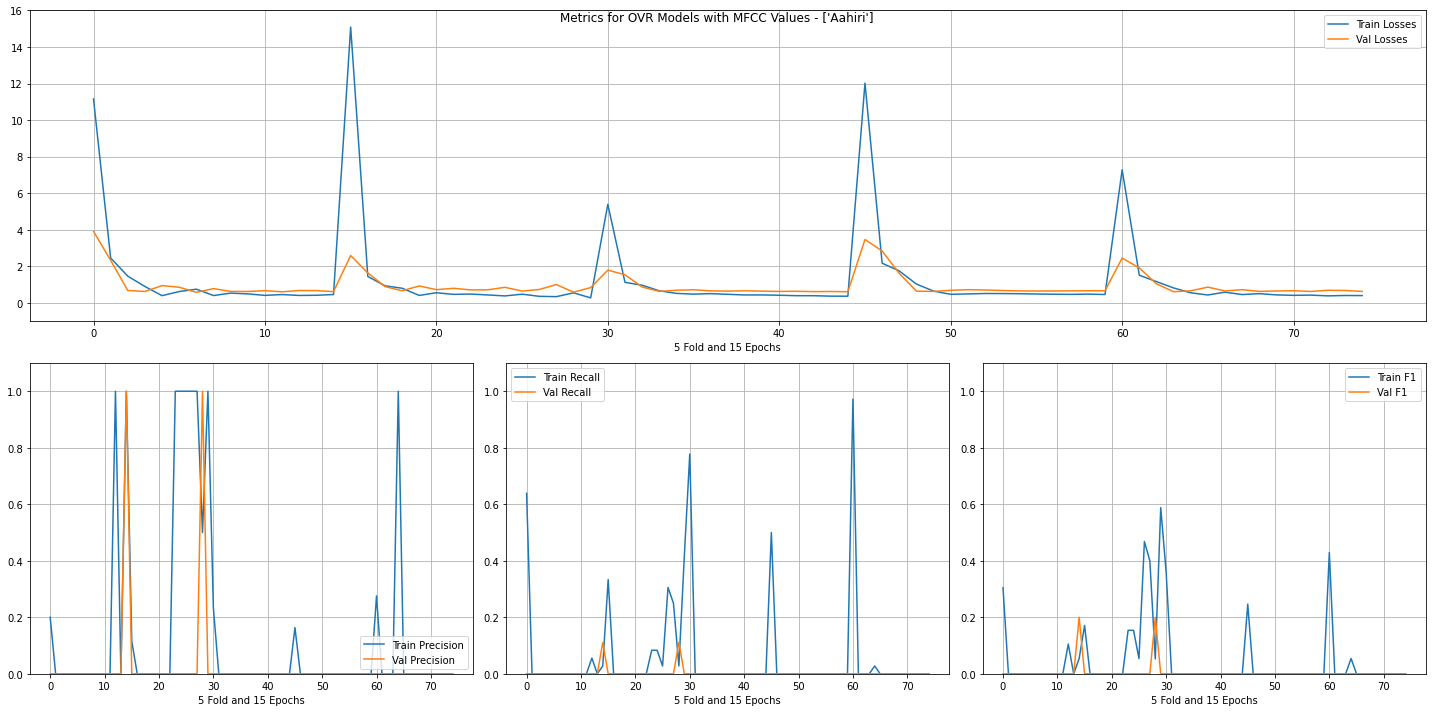

*** Cross Validation Score ***


Training for ['Bauli'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 16.020 / Validation Loss : 12.422 [Time : 0.703369 seconds]
Epoch 2/15 : Training Loss: 6.351 / Validation Loss : 13.549 [Time : 0.255829 seconds]
Epoch 3/15 : Training Loss: 6.910 / Validation Loss : 13.260 [Time : 0.247023 seconds]
Epoch 4/15 : Training Loss: 6.717 / Validation Loss : 12.259 [Time : 0.714865 seconds]
Epoch 5/15 : Training Loss: 6.171 / Validation Loss : 10.690 [Time : 0.742103 seconds]
Epoch 6/15 : Training Loss: 5.325 / Validation Loss : 8.498 [Time : 1.093648 seconds]
Epoch 7/15 : Training Loss: 4.157 / Validation Loss : 5.608 [Time : 0.724629 seconds]
Epoch 8/15 : Training Loss: 2.644 / Validation Loss : 1.726 [Time : 0.760643 seconds]
Epoch 9/15 : Training Loss: 1.836 / Validation Loss : 1.679 [Time : 0.771332 seconds]
Epoch 10/15 : Training Loss: 1.869 / Validation Loss : 0.708 [Time : 0.740856 seconds]
Epoch 11/15 : Trai

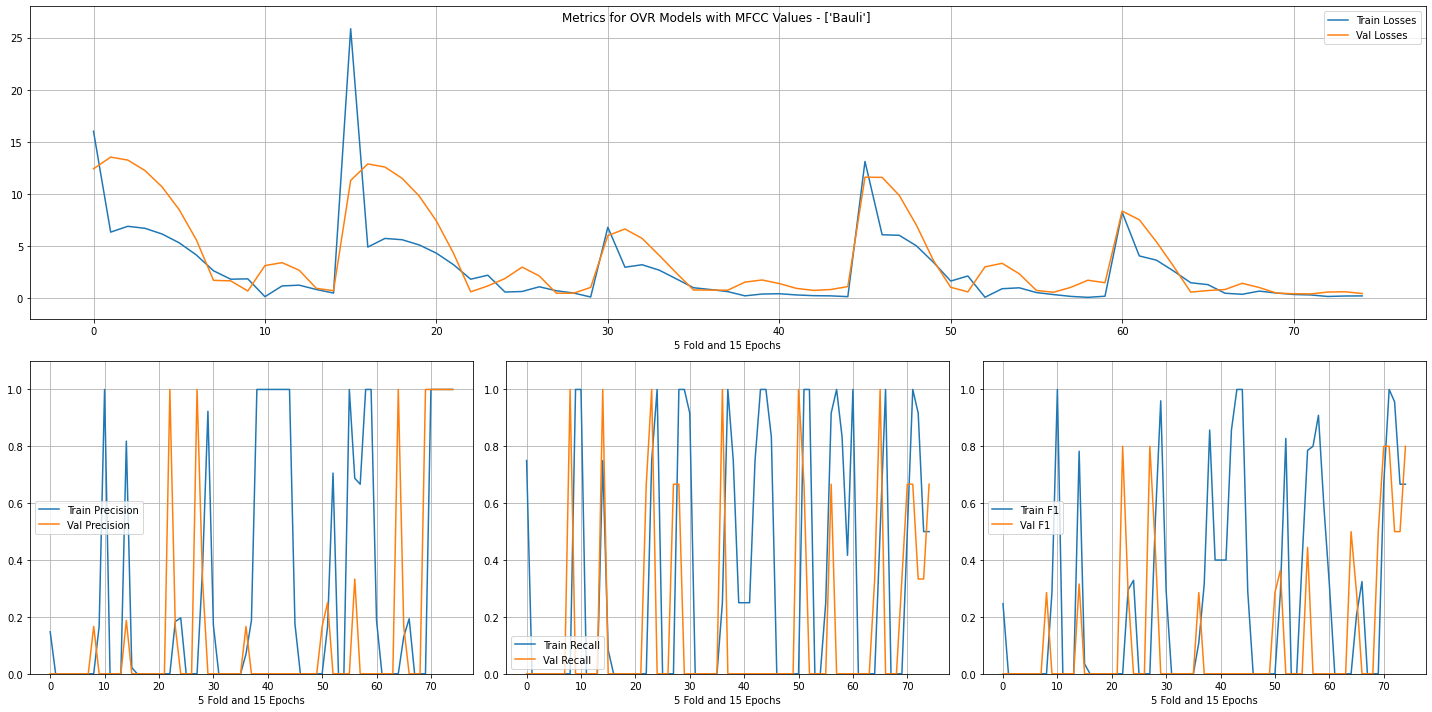

*** Cross Validation Score ***


Training for ['Bauliramakriya'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 91/23
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 22.687 / Validation Loss : 7.033 [Time : 0.778097 seconds]
Epoch 2/15 : Training Loss: 3.870 / Validation Loss : 7.692 [Time : 0.296382 seconds]
Epoch 3/15 : Training Loss: 4.330 / Validation Loss : 6.800 [Time : 0.876225 seconds]
Epoch 4/15 : Training Loss: 3.784 / Validation Loss : 5.004 [Time : 0.821411 seconds]
Epoch 5/15 : Training Loss: 2.717 / Validation Loss : 2.727 [Time : 0.800266 seconds]
Epoch 6/15 : Training Loss: 1.490 / Validation Loss : 0.784 [Time : 0.793004 seconds]
Epoch 7/15 : Training Loss: 1.322 / Validation Loss : 1.099 [Time : 0.299352 seconds]
Epoch 8/15 : Training Loss: 0.886 / Validation Loss : 0.824 [Time : 0.292493 seconds]
Epoch 9/15 : Training Loss: 0.319 / Validation Loss : 1.735 [Time : 0.281107 seconds]
Epoch 10/15 : Training Loss: 0.800 / Validation Loss : 1.624 [Time : 0.281978 seconds]
Epoch 11/15 : 

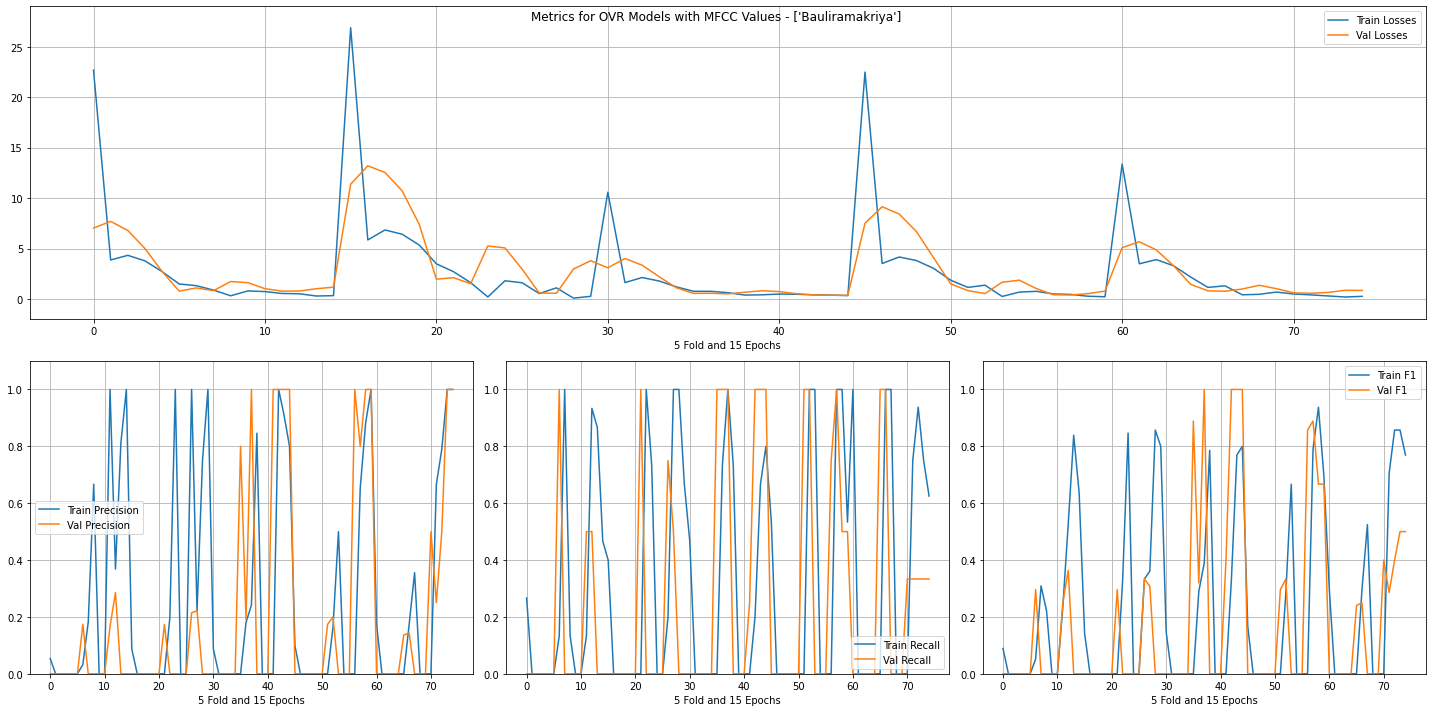

*** Cross Validation Score ***


Training for ['Bhairavi'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 134/34
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 15.933 / Validation Loss : 4.570 [Time : 0.90179 seconds]
Epoch 2/15 : Training Loss: 2.975 / Validation Loss : 3.610 [Time : 0.898811 seconds]
Epoch 3/15 : Training Loss: 2.345 / Validation Loss : 2.290 [Time : 0.912578 seconds]
Epoch 4/15 : Training Loss: 1.515 / Validation Loss : 0.564 [Time : 0.901749 seconds]
Epoch 5/15 : Training Loss: 0.661 / Validation Loss : 0.586 [Time : 0.422729 seconds]
Epoch 6/15 : Training Loss: 0.433 / Validation Loss : 0.704 [Time : 0.417443 seconds]
Epoch 7/15 : Training Loss: 0.524 / Validation Loss : 0.616 [Time : 0.412847 seconds]
Epoch 8/15 : Training Loss: 0.513 / Validation Loss : 0.564 [Time : 0.413749 seconds]
Epoch 9/15 : Training Loss: 0.458 / Validation Loss : 0.620 [Time : 0.411298 seconds]
Epoch 10/15 : Training Loss: 0.490 / Validation Loss : 0.554 [Time : 0.898625 seconds]
Epoch 11/15 : Traini

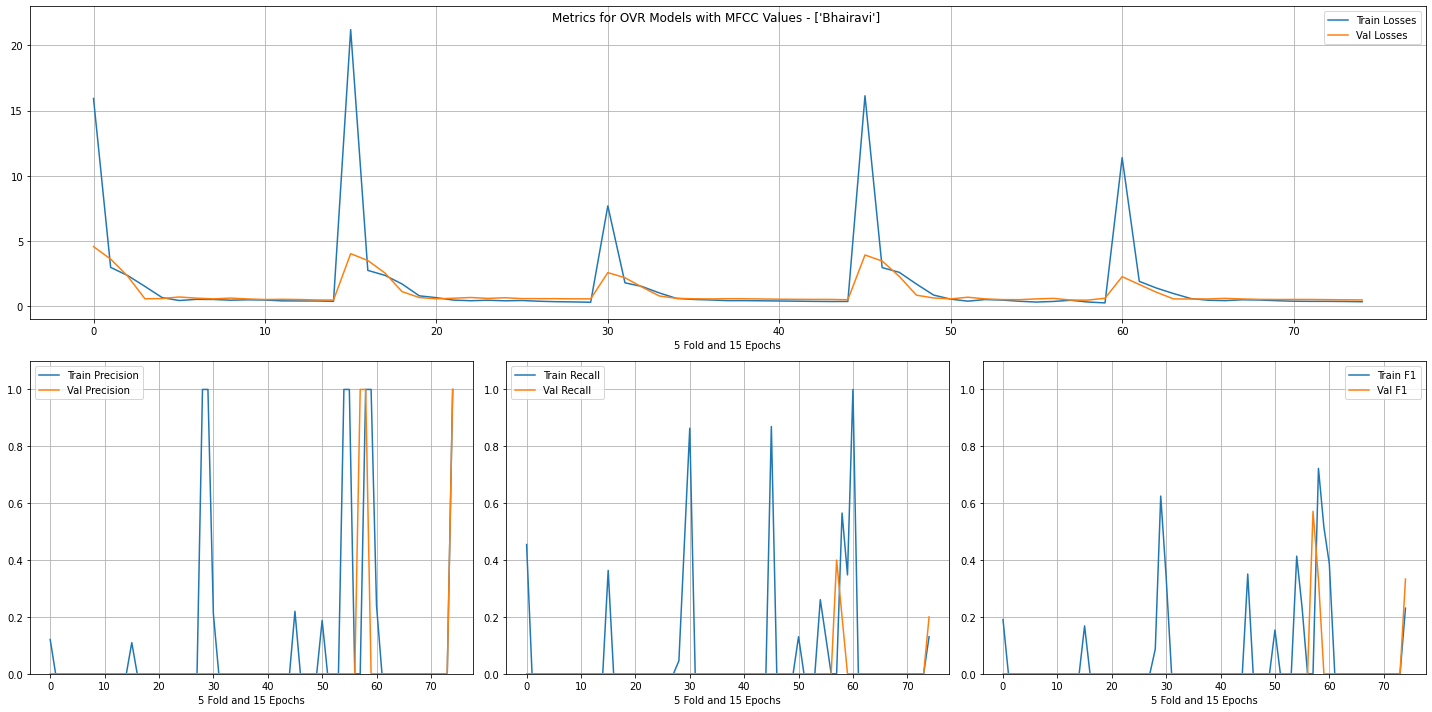

*** Cross Validation Score ***


Training for ['Bhupalam'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 72/18
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 17.286 / Validation Loss : 11.055 [Time : 0.713728 seconds]
Epoch 2/15 : Training Loss: 5.671 / Validation Loss : 12.281 [Time : 0.256068 seconds]
Epoch 3/15 : Training Loss: 6.305 / Validation Loss : 12.119 [Time : 0.252438 seconds]
Epoch 4/15 : Training Loss: 6.190 / Validation Loss : 11.298 [Time : 0.244357 seconds]
Epoch 5/15 : Training Loss: 5.729 / Validation Loss : 9.952 [Time : 0.707383 seconds]
Epoch 6/15 : Training Loss: 4.999 / Validation Loss : 8.060 [Time : 0.736017 seconds]
Epoch 7/15 : Training Loss: 3.985 / Validation Loss : 5.782 [Time : 0.736551 seconds]
Epoch 8/15 : Training Loss: 2.792 / Validation Loss : 2.965 [Time : 0.73066 seconds]
Epoch 9/15 : Training Loss: 1.442 / Validation Loss : 0.814 [Time : 0.769737 seconds]
Epoch 10/15 : Training Loss: 1.084 / Validation Loss : 0.710 [Time : 0.854633 seconds]
Epoch 11/15 : Tra

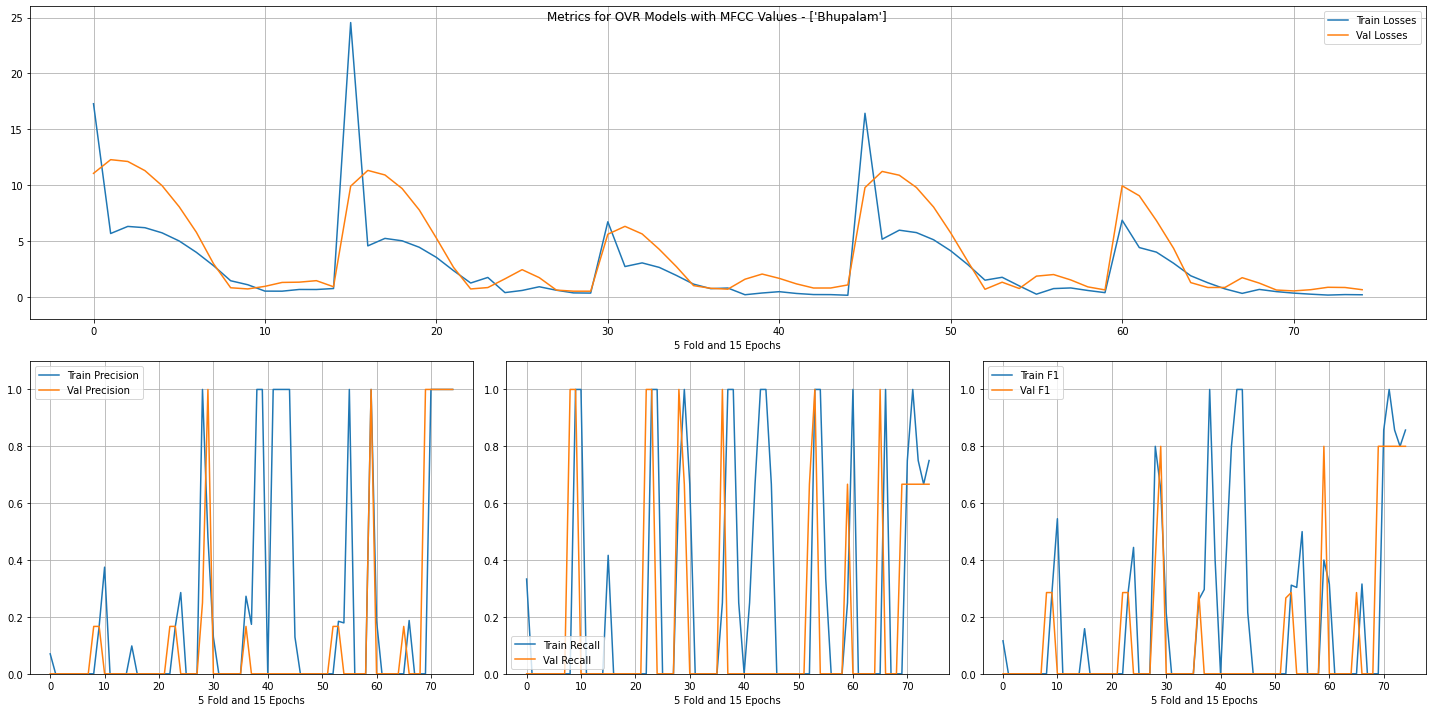

*** Cross Validation Score ***


Training for ['Desakshi'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 67/17
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 17.679 / Validation Loss : 11.402 [Time : 0.756241 seconds]
Epoch 2/15 : Training Loss: 5.119 / Validation Loss : 12.674 [Time : 0.274484 seconds]
Epoch 3/15 : Training Loss: 5.689 / Validation Loss : 12.418 [Time : 0.270304 seconds]
Epoch 4/15 : Training Loss: 5.566 / Validation Loss : 11.400 [Time : 0.740469 seconds]
Epoch 5/15 : Training Loss: 5.096 / Validation Loss : 9.746 [Time : 1.460788 seconds]
Epoch 6/15 : Training Loss: 4.345 / Validation Loss : 7.399 [Time : 0.753485 seconds]
Epoch 7/15 : Training Loss: 3.280 / Validation Loss : 4.622 [Time : 0.801352 seconds]
Epoch 8/15 : Training Loss: 2.031 / Validation Loss : 1.559 [Time : 0.7711 seconds]
Epoch 9/15 : Training Loss: 1.441 / Validation Loss : 1.197 [Time : 0.788723 seconds]
Epoch 10/15 : Training Loss: 0.908 / Validation Loss : 0.888 [Time : 0.792454 seconds]
Epoch 11/15 : Trai

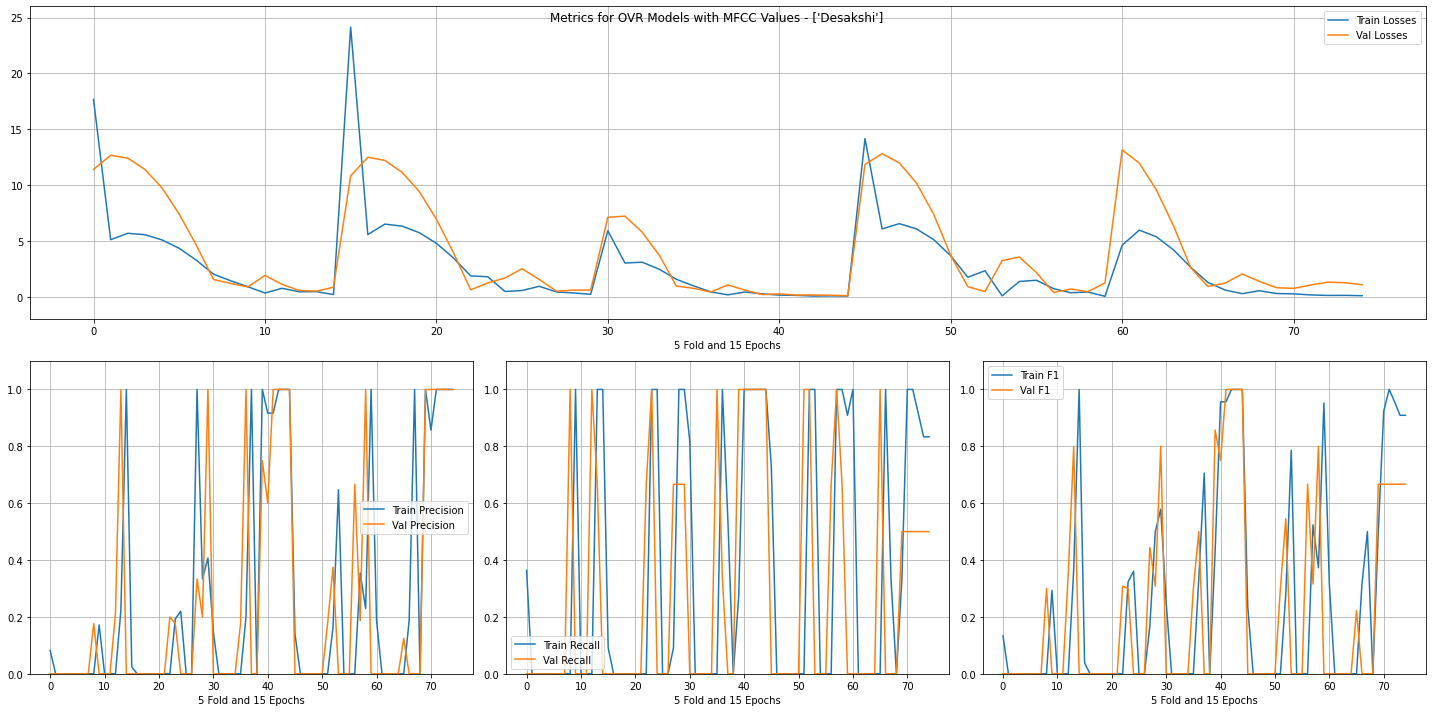

*** Cross Validation Score ***


Training for ['Desalam'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 168/42
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 14.344 / Validation Loss : 4.306 [Time : 1.015968 seconds]
Epoch 2/15 : Training Loss: 2.329 / Validation Loss : 3.210 [Time : 1.0183 seconds]
Epoch 3/15 : Training Loss: 1.731 / Validation Loss : 2.037 [Time : 1.014258 seconds]
Epoch 4/15 : Training Loss: 1.110 / Validation Loss : 0.847 [Time : 0.994591 seconds]
Epoch 5/15 : Training Loss: 0.589 / Validation Loss : 0.609 [Time : 1.007982 seconds]
Epoch 6/15 : Training Loss: 0.503 / Validation Loss : 0.613 [Time : 0.539653 seconds]
Epoch 7/15 : Training Loss: 0.413 / Validation Loss : 0.695 [Time : 0.518193 seconds]
Epoch 8/15 : Training Loss: 0.430 / Validation Loss : 0.724 [Time : 0.53057 seconds]
Epoch 9/15 : Training Loss: 0.455 / Validation Loss : 0.684 [Time : 0.521841 seconds]
Epoch 10/15 : Training Loss: 0.455 / Validation Loss : 0.636 [Time : 0.531387 seconds]
Epoch 11/15 : Training 

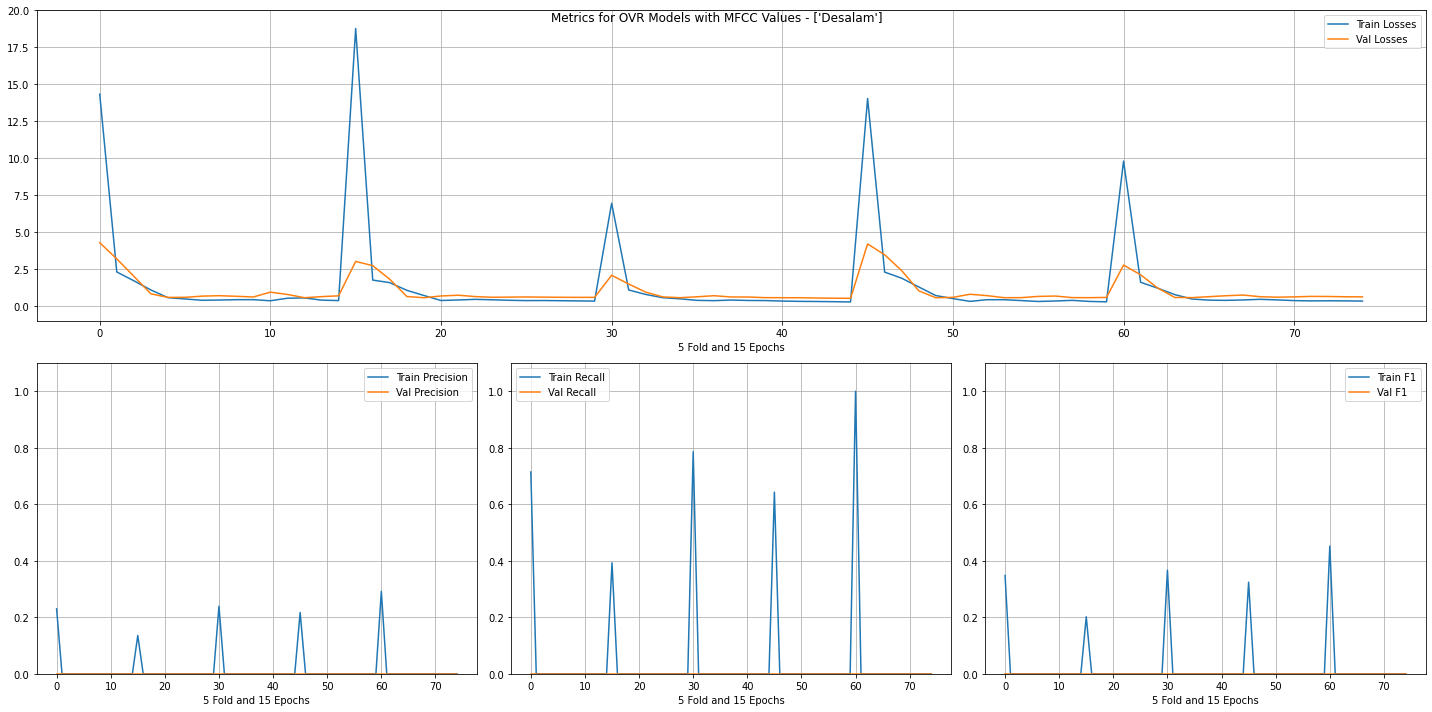

*** Cross Validation Score ***


Training for ['Devagandhari'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 139/35
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 17.210 / Validation Loss : 2.782 [Time : 0.903041 seconds]
Epoch 2/15 : Training Loss: 1.969 / Validation Loss : 2.292 [Time : 0.936505 seconds]
Epoch 3/15 : Training Loss: 1.628 / Validation Loss : 1.362 [Time : 0.910899 seconds]
Epoch 4/15 : Training Loss: 1.027 / Validation Loss : 0.584 [Time : 0.918201 seconds]
Epoch 5/15 : Training Loss: 0.510 / Validation Loss : 0.603 [Time : 0.429456 seconds]
Epoch 6/15 : Training Loss: 0.510 / Validation Loss : 0.590 [Time : 0.424661 seconds]
Epoch 7/15 : Training Loss: 0.485 / Validation Loss : 0.625 [Time : 0.427814 seconds]
Epoch 8/15 : Training Loss: 0.520 / Validation Loss : 0.586 [Time : 0.427173 seconds]
Epoch 9/15 : Training Loss: 0.492 / Validation Loss : 0.584 [Time : 0.422776 seconds]
Epoch 10/15 : Training Loss: 0.489 / Validation Loss : 0.566 [Time : 1.082171 seconds]
Epoch 11/15 : T

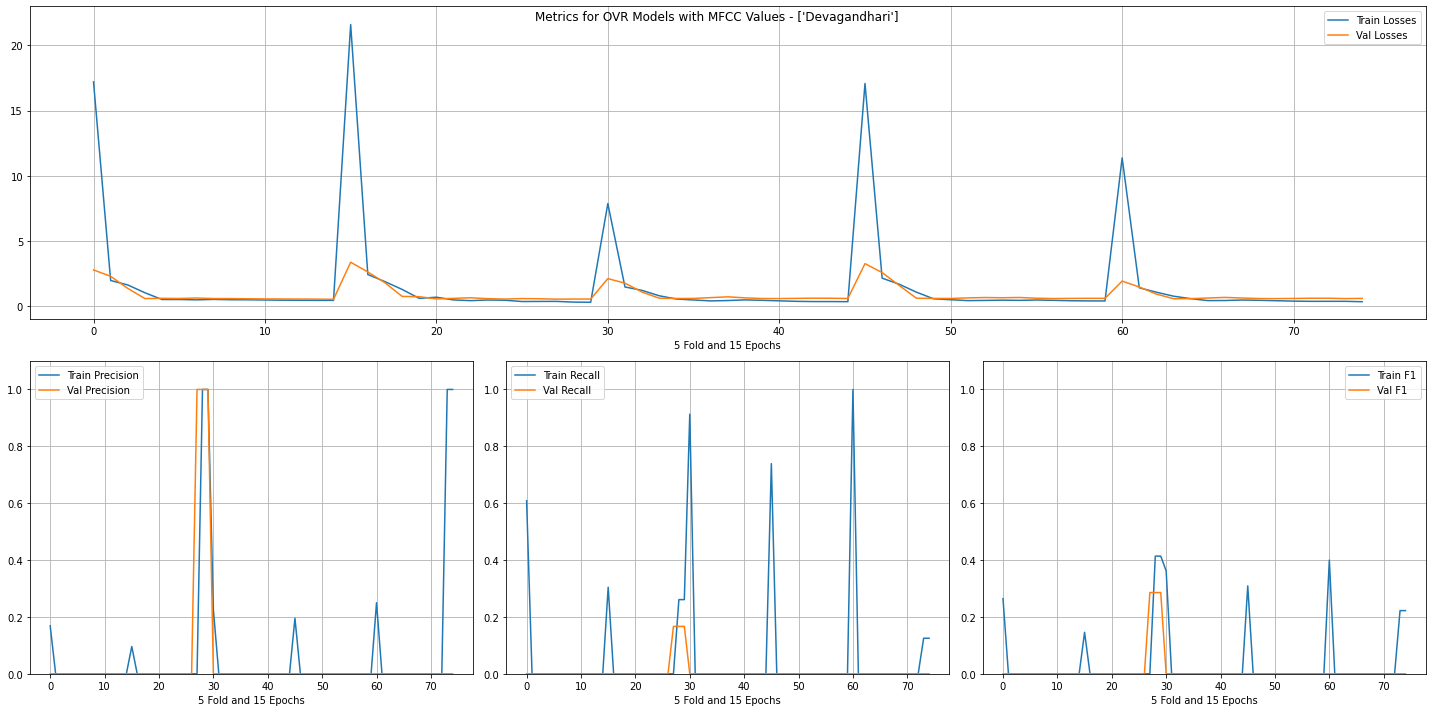

*** Cross Validation Score ***


Training for ['Dhannasi'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 192/48
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 14.786 / Validation Loss : 3.639 [Time : 1.049206 seconds]
Epoch 2/15 : Training Loss: 1.953 / Validation Loss : 2.393 [Time : 1.040644 seconds]
Epoch 3/15 : Training Loss: 1.314 / Validation Loss : 0.740 [Time : 1.035179 seconds]
Epoch 4/15 : Training Loss: 0.811 / Validation Loss : 0.642 [Time : 1.039951 seconds]
Epoch 5/15 : Training Loss: 0.368 / Validation Loss : 0.998 [Time : 0.578937 seconds]
Epoch 6/15 : Training Loss: 0.574 / Validation Loss : 0.786 [Time : 0.563713 seconds]
Epoch 7/15 : Training Loss: 0.566 / Validation Loss : 0.627 [Time : 1.036597 seconds]
Epoch 8/15 : Training Loss: 0.424 / Validation Loss : 0.733 [Time : 0.574362 seconds]
Epoch 9/15 : Training Loss: 0.431 / Validation Loss : 0.740 [Time : 0.568816 seconds]
Epoch 10/15 : Training Loss: 0.468 / Validation Loss : 0.652 [Time : 0.574285 seconds]
Epoch 11/15 : Train

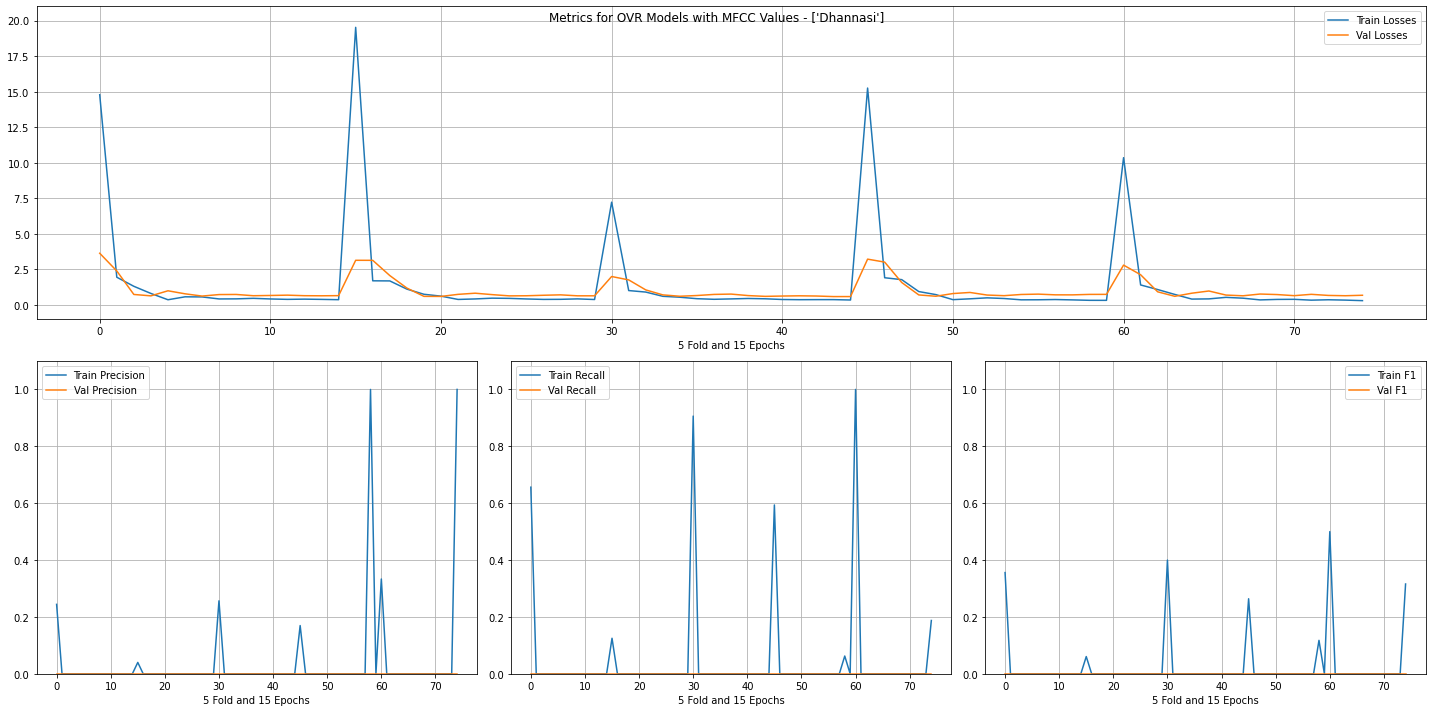

*** Cross Validation Score ***


Training for ['Gowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 23.600 / Validation Loss : 5.231 [Time : 0.802898 seconds]
Epoch 2/15 : Training Loss: 3.083 / Validation Loss : 6.038 [Time : 0.311726 seconds]
Epoch 3/15 : Training Loss: 3.567 / Validation Loss : 5.391 [Time : 0.308874 seconds]
Epoch 4/15 : Training Loss: 3.171 / Validation Loss : 4.198 [Time : 0.774766 seconds]
Epoch 5/15 : Training Loss: 2.452 / Validation Loss : 2.748 [Time : 0.806031 seconds]
Epoch 6/15 : Training Loss: 1.621 / Validation Loss : 1.490 [Time : 0.797938 seconds]
Epoch 7/15 : Training Loss: 0.993 / Validation Loss : 0.654 [Time : 0.795113 seconds]
Epoch 8/15 : Training Loss: 0.779 / Validation Loss : 0.699 [Time : 0.317274 seconds]
Epoch 9/15 : Training Loss: 0.709 / Validation Loss : 0.690 [Time : 0.309756 seconds]
Epoch 10/15 : Training Loss: 0.651 / Validation Loss : 0.692 [Time : 0.302996 seconds]
Epoch 11/15 : Training 

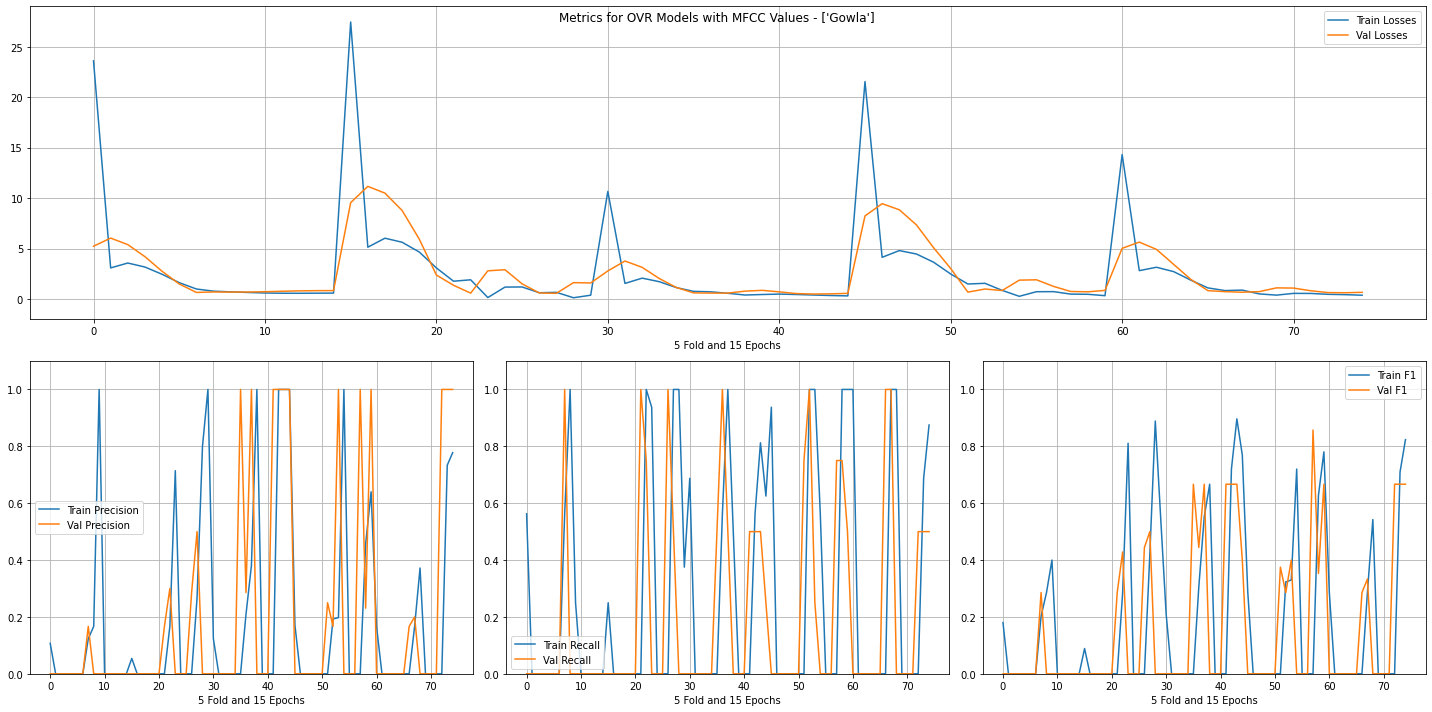

*** Cross Validation Score ***


Training for ['Gujjari'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 120/30
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 19.307 / Validation Loss : 6.485 [Time : 0.848151 seconds]
Epoch 2/15 : Training Loss: 3.028 / Validation Loss : 6.095 [Time : 0.87032 seconds]
Epoch 3/15 : Training Loss: 2.825 / Validation Loss : 5.069 [Time : 0.873379 seconds]
Epoch 4/15 : Training Loss: 2.331 / Validation Loss : 3.420 [Time : 0.868374 seconds]
Epoch 5/15 : Training Loss: 1.548 / Validation Loss : 1.737 [Time : 0.892482 seconds]
Epoch 6/15 : Training Loss: 0.866 / Validation Loss : 0.812 [Time : 0.862638 seconds]
Epoch 7/15 : Training Loss: 0.733 / Validation Loss : 0.685 [Time : 0.87223 seconds]
Epoch 8/15 : Training Loss: 0.523 / Validation Loss : 0.960 [Time : 0.389822 seconds]
Epoch 9/15 : Training Loss: 0.461 / Validation Loss : 1.184 [Time : 0.378492 seconds]
Epoch 10/15 : Training Loss: 0.552 / Validation Loss : 1.020 [Time : 0.3734 seconds]
Epoch 11/15 : Training L

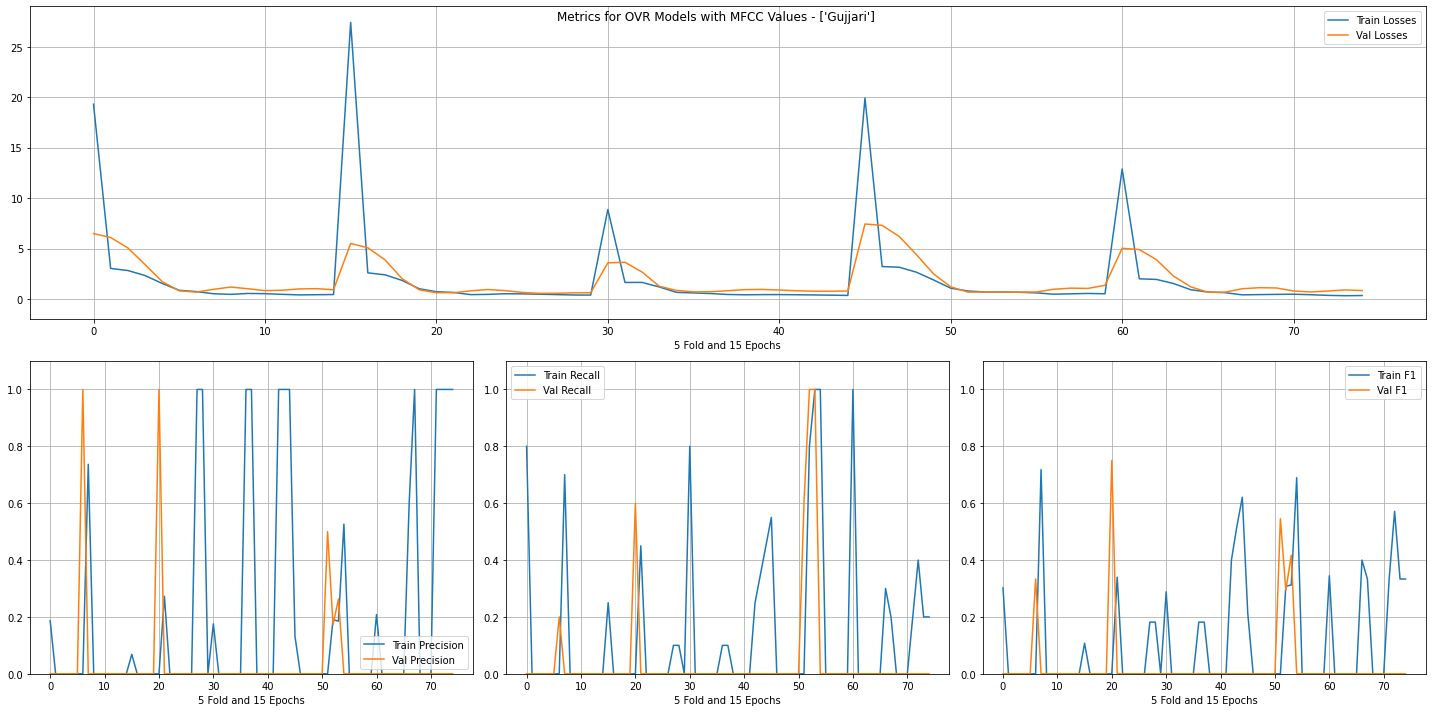

*** Cross Validation Score ***


Training for ['Gundukriya'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 14.492 / Validation Loss : 4.222 [Time : 0.651114 seconds]
Epoch 2/15 : Training Loss: 1.652 / Validation Loss : 6.164 [Time : 0.193517 seconds]
Epoch 3/15 : Training Loss: 2.568 / Validation Loss : 1.738 [Time : 0.662974 seconds]
Epoch 4/15 : Training Loss: 1.787 / Validation Loss : 1.108 [Time : 0.688094 seconds]
Epoch 5/15 : Training Loss: 0.070 / Validation Loss : 5.346 [Time : 0.199856 seconds]
Epoch 6/15 : Training Loss: 1.234 / Validation Loss : 3.741 [Time : 0.207927 seconds]
Epoch 7/15 : Training Loss: 0.389 / Validation Loss : 1.416 [Time : 0.191803 seconds]
Epoch 8/15 : Training Loss: 0.575 / Validation Loss : 1.196 [Time : 0.191136 seconds]
Epoch 9/15 : Training Loss: 0.103 / Validation Loss : 2.931 [Time : 0.186405 seconds]
Epoch 10/15 : Training Loss: 0.022 / Validation Loss : 4.127 [Time : 0.189835 seconds]
Epoch 11/15 : Trai

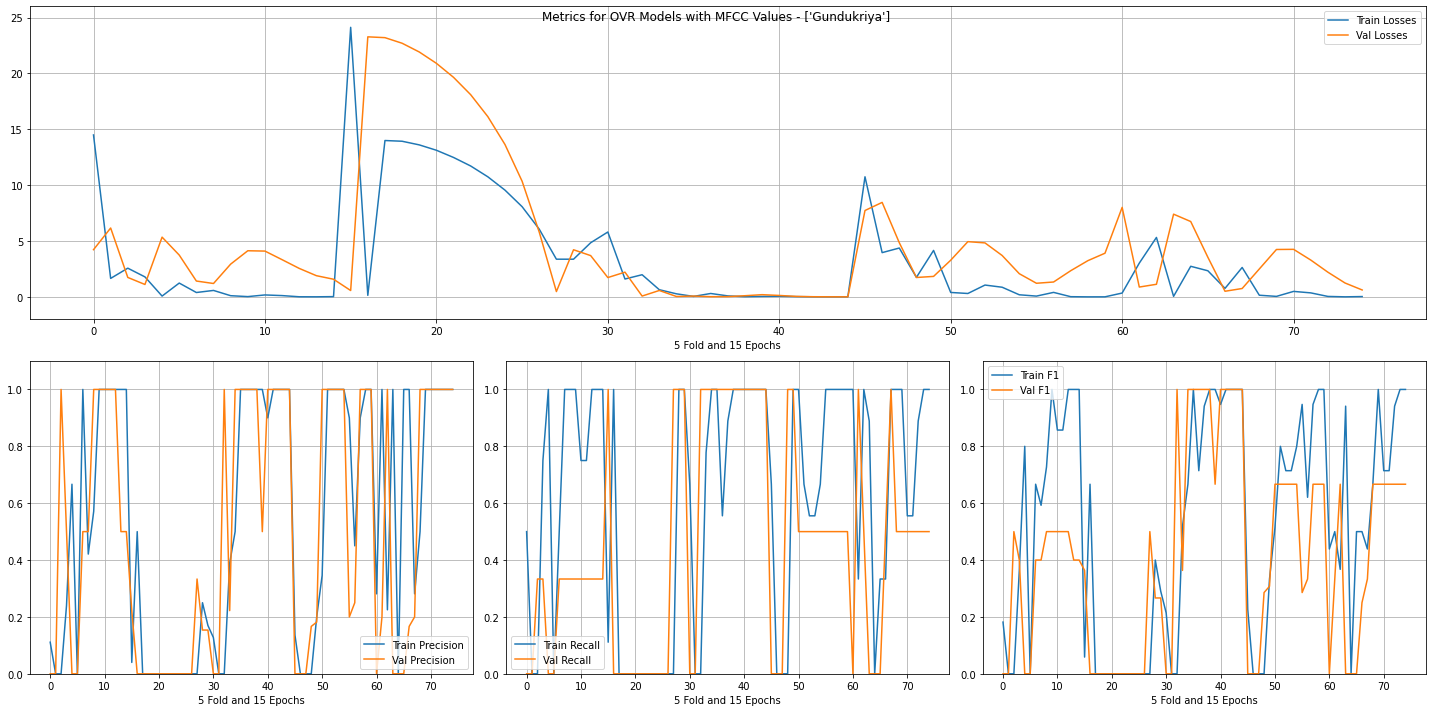

*** Cross Validation Score ***


Training for ['Kambodhi'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 235/59
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.130 / Validation Loss : 4.582 [Time : 1.187839 seconds]
Epoch 2/15 : Training Loss: 2.610 / Validation Loss : 2.789 [Time : 1.18611 seconds]
Epoch 3/15 : Training Loss: 1.544 / Validation Loss : 1.155 [Time : 1.193611 seconds]
Epoch 4/15 : Training Loss: 0.876 / Validation Loss : 0.631 [Time : 1.175852 seconds]
Epoch 5/15 : Training Loss: 0.497 / Validation Loss : 0.795 [Time : 0.706127 seconds]
Epoch 6/15 : Training Loss: 0.481 / Validation Loss : 1.064 [Time : 0.694244 seconds]
Epoch 7/15 : Training Loss: 0.696 / Validation Loss : 0.691 [Time : 0.689915 seconds]
Epoch 8/15 : Training Loss: 0.529 / Validation Loss : 0.708 [Time : 0.704406 seconds]
Epoch 9/15 : Training Loss: 0.449 / Validation Loss : 0.772 [Time : 0.708257 seconds]
Epoch 10/15 : Training Loss: 0.499 / Validation Loss : 0.695 [Time : 0.706096 seconds]
Epoch 11/15 : Traini

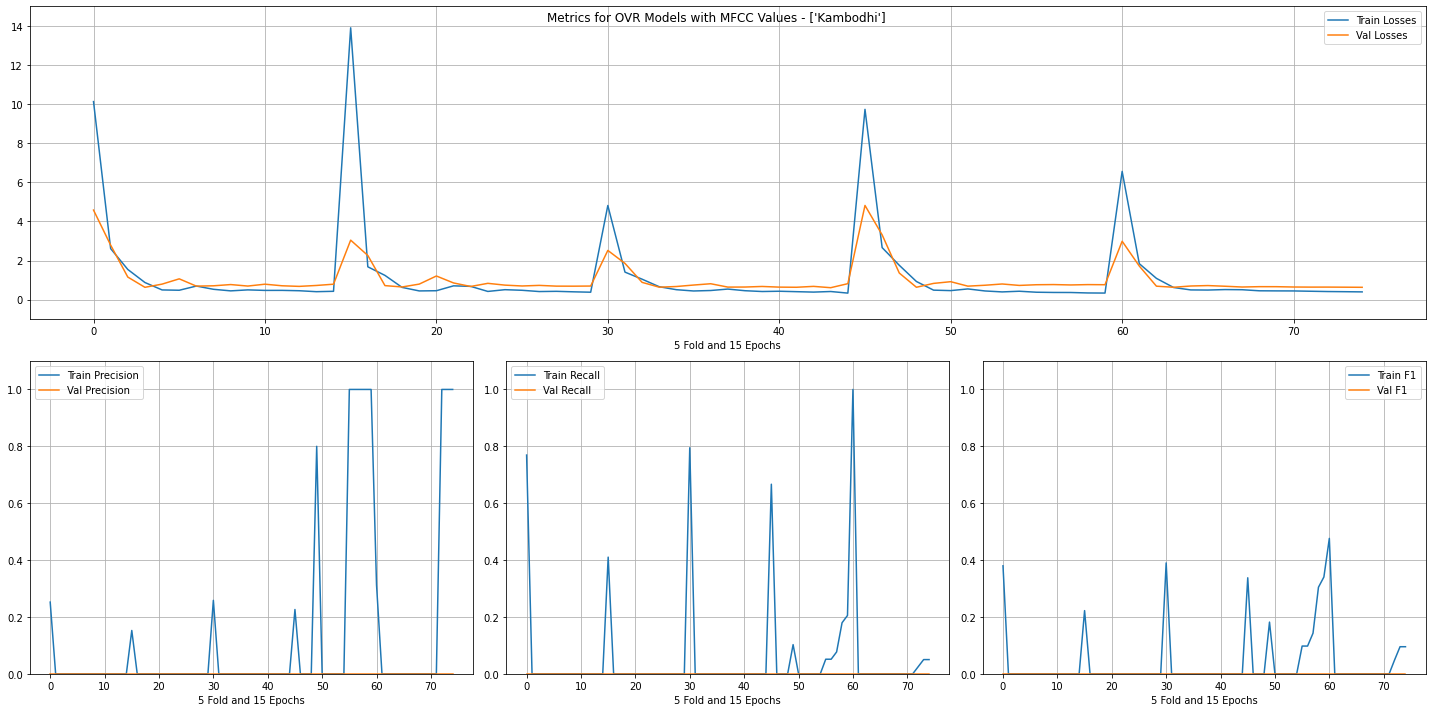

*** Cross Validation Score ***


Training for ['Kannadagowla'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 336/84
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 13.426 / Validation Loss : 5.904 [Time : 1.502422 seconds]
Epoch 2/15 : Training Loss: 4.002 / Validation Loss : 3.711 [Time : 1.503692 seconds]
Epoch 3/15 : Training Loss: 2.454 / Validation Loss : 1.796 [Time : 1.496643 seconds]
Epoch 4/15 : Training Loss: 1.441 / Validation Loss : 0.595 [Time : 1.505939 seconds]
Epoch 5/15 : Training Loss: 0.458 / Validation Loss : 0.837 [Time : 1.045285 seconds]
Epoch 6/15 : Training Loss: 0.678 / Validation Loss : 0.604 [Time : 1.007377 seconds]
Epoch 7/15 : Training Loss: 0.519 / Validation Loss : 0.756 [Time : 1.00105 seconds]
Epoch 8/15 : Training Loss: 0.612 / Validation Loss : 0.607 [Time : 1.006455 seconds]
Epoch 9/15 : Training Loss: 0.468 / Validation Loss : 0.919 [Time : 1.002382 seconds]
Epoch 10/15 : Training Loss: 0.760 / Validation Loss : 0.631 [Time : 1.00206 seconds]
Epoch 11/15 : Tra

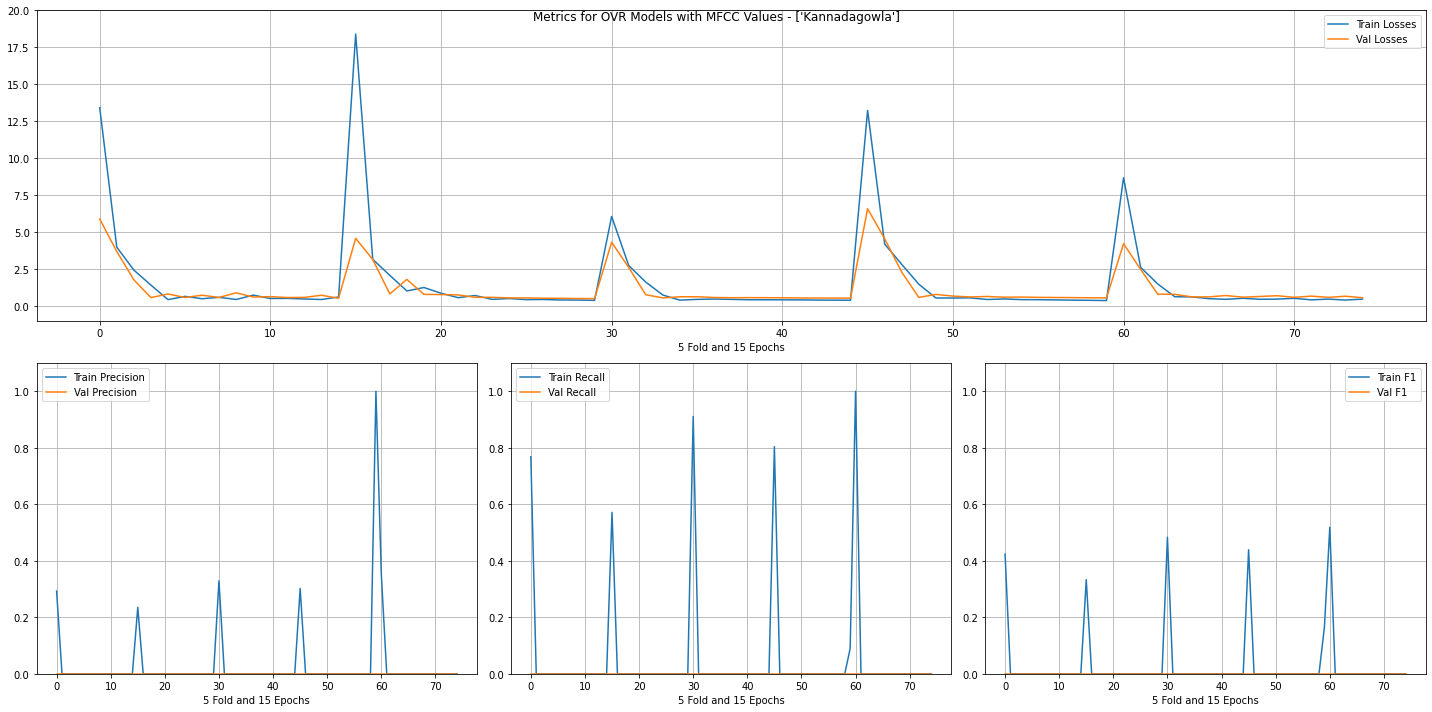

*** Cross Validation Score ***


Training for ['Lalitha'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 62/16
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 19.138 / Validation Loss : 1.121 [Time : 0.690349 seconds]
Epoch 2/15 : Training Loss: 0.289 / Validation Loss : 11.998 [Time : 0.223623 seconds]
Epoch 3/15 : Training Loss: 6.501 / Validation Loss : 10.796 [Time : 0.227584 seconds]
Epoch 4/15 : Training Loss: 5.618 / Validation Loss : 7.203 [Time : 0.218016 seconds]
Epoch 5/15 : Training Loss: 3.245 / Validation Loss : 0.718 [Time : 0.70929 seconds]
Epoch 6/15 : Training Loss: 4.725 / Validation Loss : 3.428 [Time : 0.22008 seconds]
Epoch 7/15 : Training Loss: 2.579 / Validation Loss : 2.585 [Time : 0.222992 seconds]
Epoch 8/15 : Training Loss: 0.256 / Validation Loss : 9.036 [Time : 0.220865 seconds]
Epoch 9/15 : Training Loss: 3.310 / Validation Loss : 9.578 [Time : 0.222851 seconds]
Epoch 10/15 : Training Loss: 3.512 / Validation Loss : 8.232 [Time : 0.216892 seconds]
Epoch 11/15 : Trainin

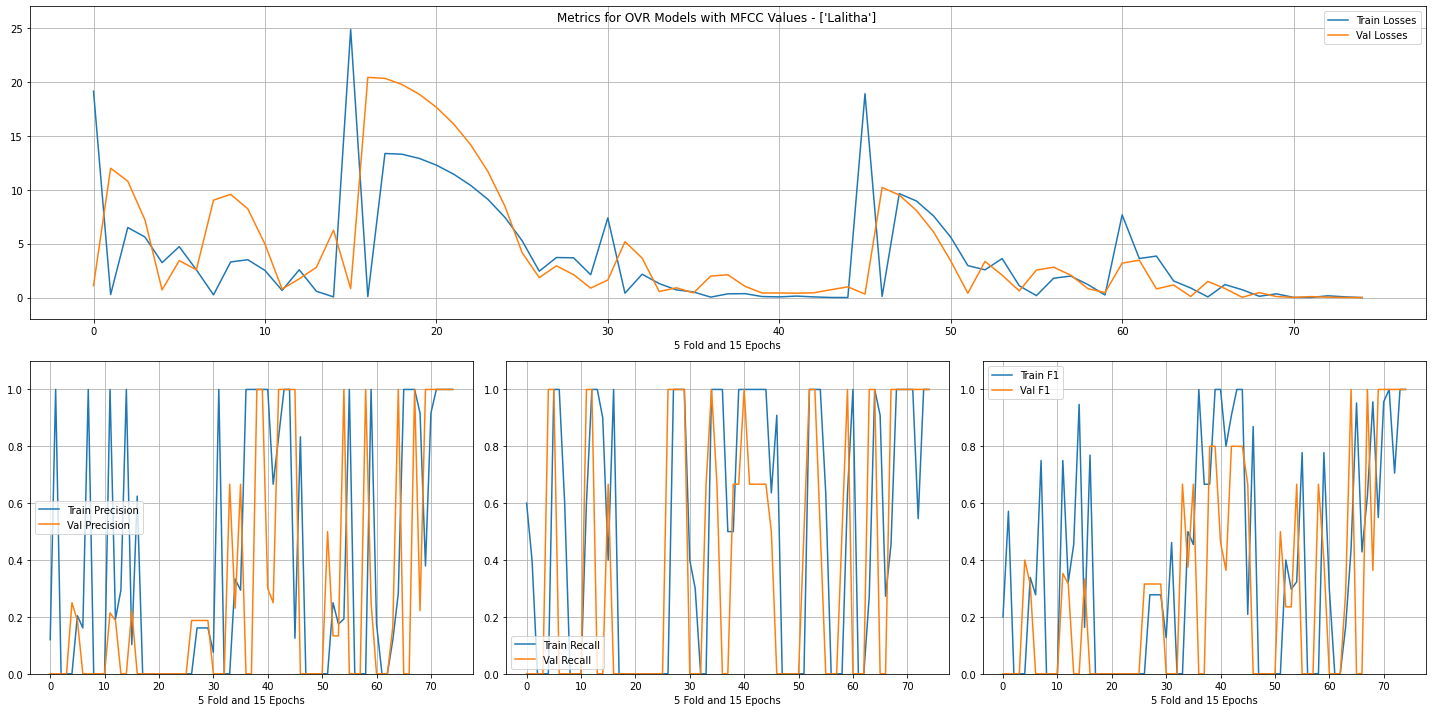

*** Cross Validation Score ***


Training for ['Maalavi'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 153/39
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 17.738 / Validation Loss : 3.186 [Time : 0.960593 seconds]
Epoch 2/15 : Training Loss: 1.958 / Validation Loss : 3.131 [Time : 0.94736 seconds]
Epoch 3/15 : Training Loss: 1.911 / Validation Loss : 1.821 [Time : 1.147719 seconds]
Epoch 4/15 : Training Loss: 1.137 / Validation Loss : 0.750 [Time : 0.97014 seconds]
Epoch 5/15 : Training Loss: 0.564 / Validation Loss : 0.642 [Time : 0.953782 seconds]
Epoch 6/15 : Training Loss: 0.536 / Validation Loss : 0.619 [Time : 0.936061 seconds]
Epoch 7/15 : Training Loss: 0.424 / Validation Loss : 0.867 [Time : 0.480906 seconds]
Epoch 8/15 : Training Loss: 0.557 / Validation Loss : 0.987 [Time : 0.461293 seconds]
Epoch 9/15 : Training Loss: 0.674 / Validation Loss : 0.660 [Time : 0.459564 seconds]
Epoch 10/15 : Training Loss: 0.519 / Validation Loss : 0.752 [Time : 0.459337 seconds]
Epoch 11/15 : Training

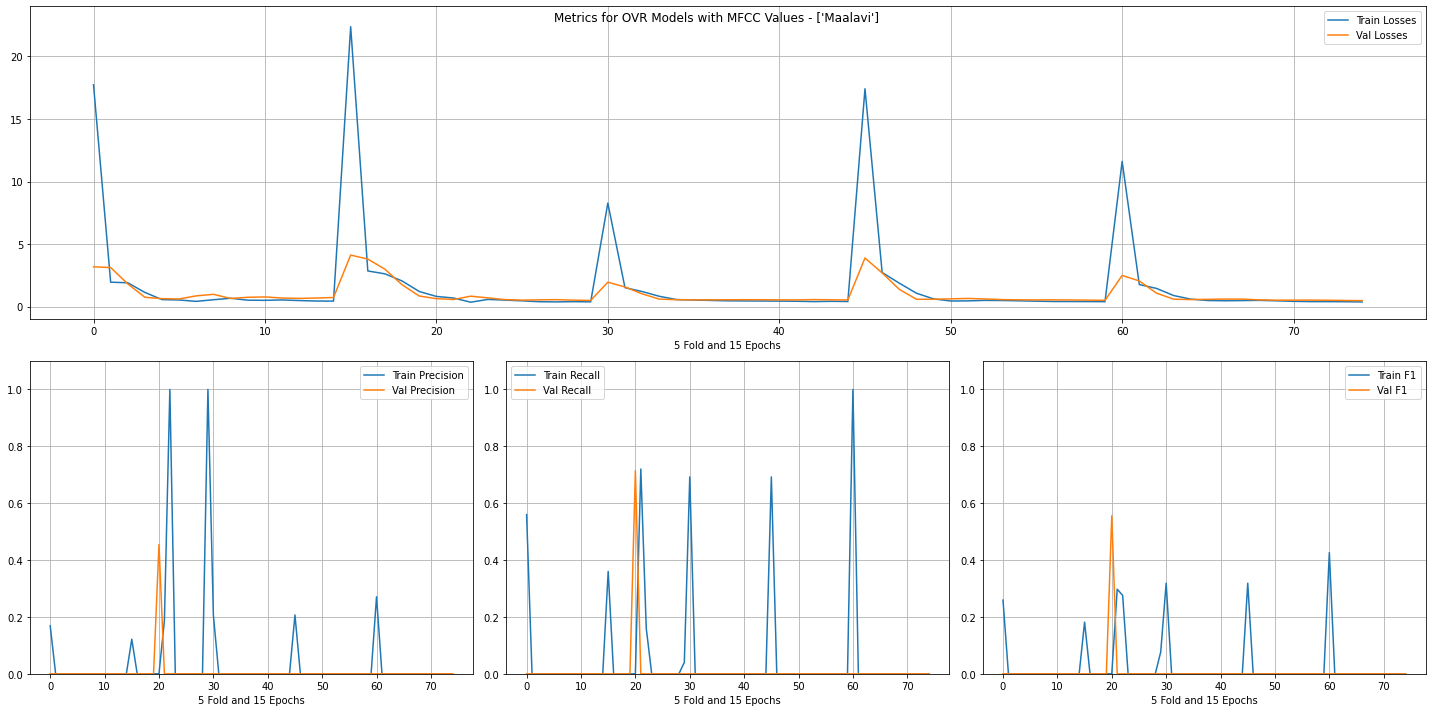

*** Cross Validation Score ***


Training for ['Malahari'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 129/33
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 16.304 / Validation Loss : 4.365 [Time : 0.898995 seconds]
Epoch 2/15 : Training Loss: 3.072 / Validation Loss : 3.895 [Time : 0.897702 seconds]
Epoch 3/15 : Training Loss: 2.750 / Validation Loss : 2.927 [Time : 0.907104 seconds]
Epoch 4/15 : Training Loss: 2.072 / Validation Loss : 1.680 [Time : 1.023338 seconds]
Epoch 5/15 : Training Loss: 1.218 / Validation Loss : 0.750 [Time : 0.935518 seconds]
Epoch 6/15 : Training Loss: 0.844 / Validation Loss : 0.616 [Time : 0.926728 seconds]
Epoch 7/15 : Training Loss: 0.514 / Validation Loss : 0.576 [Time : 0.900805 seconds]
Epoch 8/15 : Training Loss: 0.412 / Validation Loss : 0.782 [Time : 0.420601 seconds]
Epoch 9/15 : Training Loss: 0.590 / Validation Loss : 0.732 [Time : 0.416128 seconds]
Epoch 10/15 : Training Loss: 0.688 / Validation Loss : 0.489 [Time : 0.899081 seconds]
Epoch 11/15 : Train

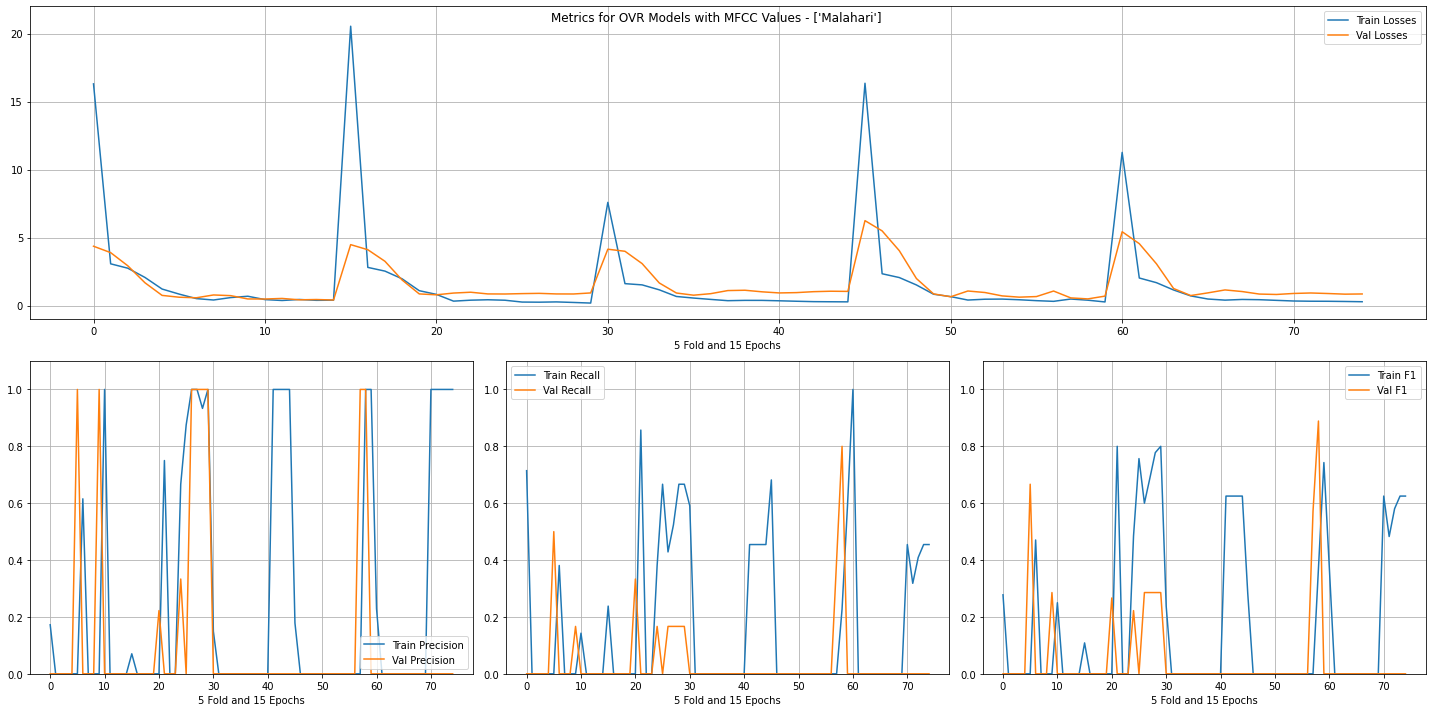

*** Cross Validation Score ***


Training for ['Malavigowla'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 96/24
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 23.955 / Validation Loss : 5.867 [Time : 0.785894 seconds]
Epoch 2/15 : Training Loss: 3.444 / Validation Loss : 6.743 [Time : 0.318226 seconds]
Epoch 3/15 : Training Loss: 3.921 / Validation Loss : 6.089 [Time : 0.314873 seconds]
Epoch 4/15 : Training Loss: 3.528 / Validation Loss : 4.670 [Time : 0.790399 seconds]
Epoch 5/15 : Training Loss: 2.696 / Validation Loss : 2.891 [Time : 0.806938 seconds]
Epoch 6/15 : Training Loss: 1.682 / Validation Loss : 0.955 [Time : 0.814786 seconds]
Epoch 7/15 : Training Loss: 1.200 / Validation Loss : 0.976 [Time : 0.314078 seconds]
Epoch 8/15 : Training Loss: 1.170 / Validation Loss : 0.645 [Time : 0.796837 seconds]
Epoch 9/15 : Training Loss: 0.345 / Validation Loss : 1.121 [Time : 0.317734 seconds]
Epoch 10/15 : Training Loss: 0.598 / Validation Loss : 1.484 [Time : 0.312552 seconds]
Epoch 11/15 : Tra

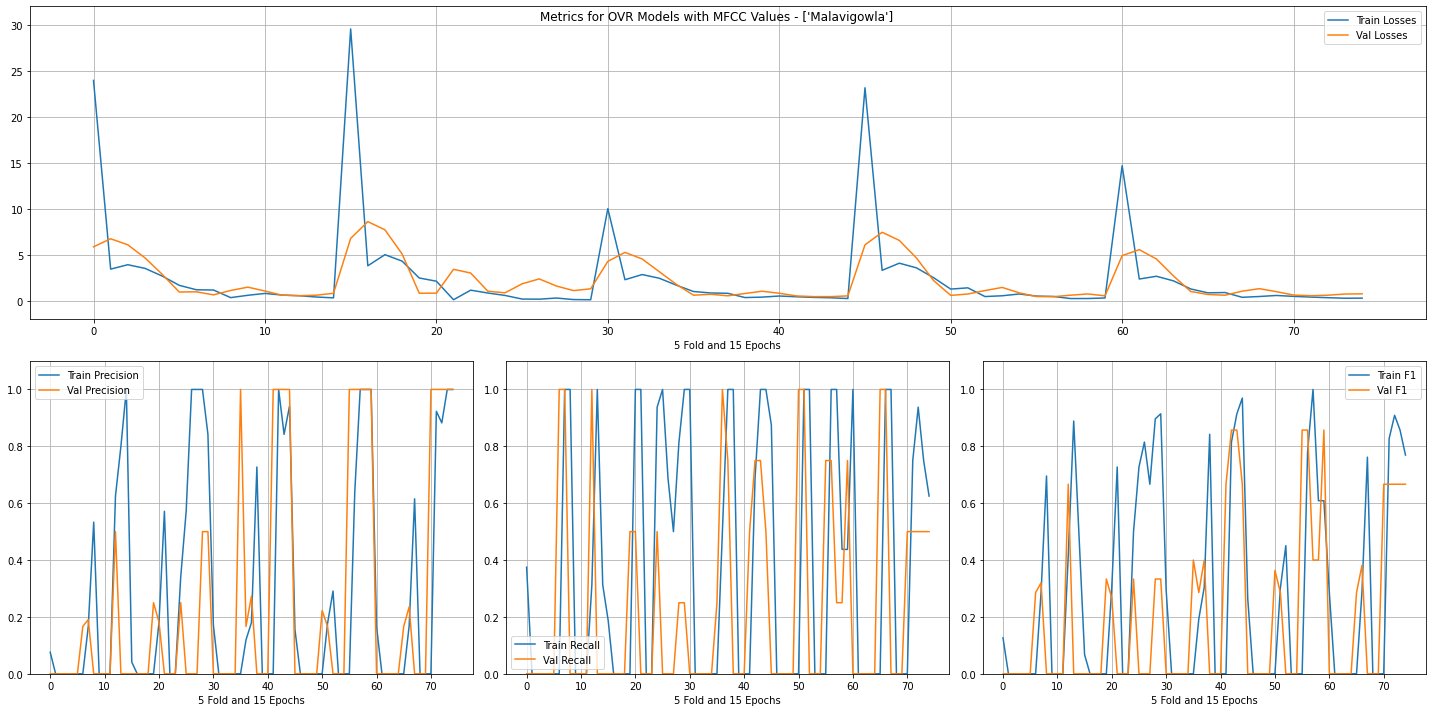

*** Cross Validation Score ***


Training for ['Mukhari'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 20.873 / Validation Loss : 9.269 [Time : 0.7501 seconds]
Epoch 2/15 : Training Loss: 4.311 / Validation Loss : 10.354 [Time : 0.299799 seconds]
Epoch 3/15 : Training Loss: 4.794 / Validation Loss : 9.884 [Time : 0.287657 seconds]
Epoch 4/15 : Training Loss: 4.513 / Validation Loss : 8.612 [Time : 0.760594 seconds]
Epoch 5/15 : Training Loss: 3.868 / Validation Loss : 6.675 [Time : 0.780807 seconds]
Epoch 6/15 : Training Loss: 2.918 / Validation Loss : 4.451 [Time : 0.763781 seconds]
Epoch 7/15 : Training Loss: 1.882 / Validation Loss : 2.070 [Time : 0.776875 seconds]
Epoch 8/15 : Training Loss: 1.066 / Validation Loss : 0.799 [Time : 0.833049 seconds]
Epoch 9/15 : Training Loss: 1.046 / Validation Loss : 0.705 [Time : 0.793728 seconds]
Epoch 10/15 : Training Loss: 0.501 / Validation Loss : 1.088 [Time : 0.297269 seconds]
Epoch 11/15 : Training

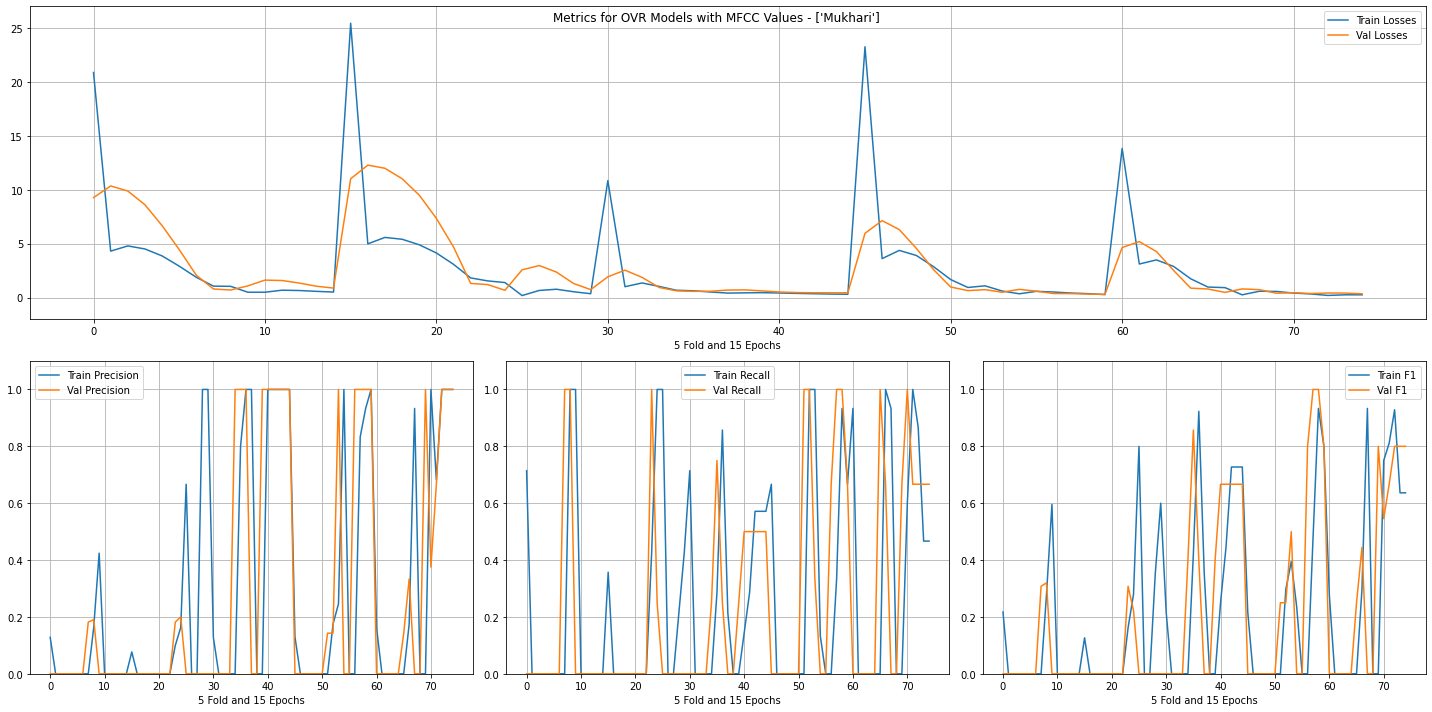

*** Cross Validation Score ***


Training for ['Naata'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 86/22
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 19.783 / Validation Loss : 9.282 [Time : 0.752735 seconds]
Epoch 2/15 : Training Loss: 4.774 / Validation Loss : 10.262 [Time : 0.29323 seconds]
Epoch 3/15 : Training Loss: 5.314 / Validation Loss : 9.892 [Time : 0.290216 seconds]
Epoch 4/15 : Training Loss: 5.098 / Validation Loss : 8.815 [Time : 0.763444 seconds]
Epoch 5/15 : Training Loss: 4.504 / Validation Loss : 7.153 [Time : 0.777331 seconds]
Epoch 6/15 : Training Loss: 3.607 / Validation Loss : 5.121 [Time : 1.089359 seconds]
Epoch 7/15 : Training Loss: 2.561 / Validation Loss : 2.893 [Time : 0.774176 seconds]
Epoch 8/15 : Training Loss: 1.450 / Validation Loss : 0.688 [Time : 0.791217 seconds]
Epoch 9/15 : Training Loss: 0.956 / Validation Loss : 0.710 [Time : 0.293408 seconds]
Epoch 10/15 : Training Loss: 0.683 / Validation Loss : 0.727 [Time : 0.289507 seconds]
Epoch 11/15 : Training 

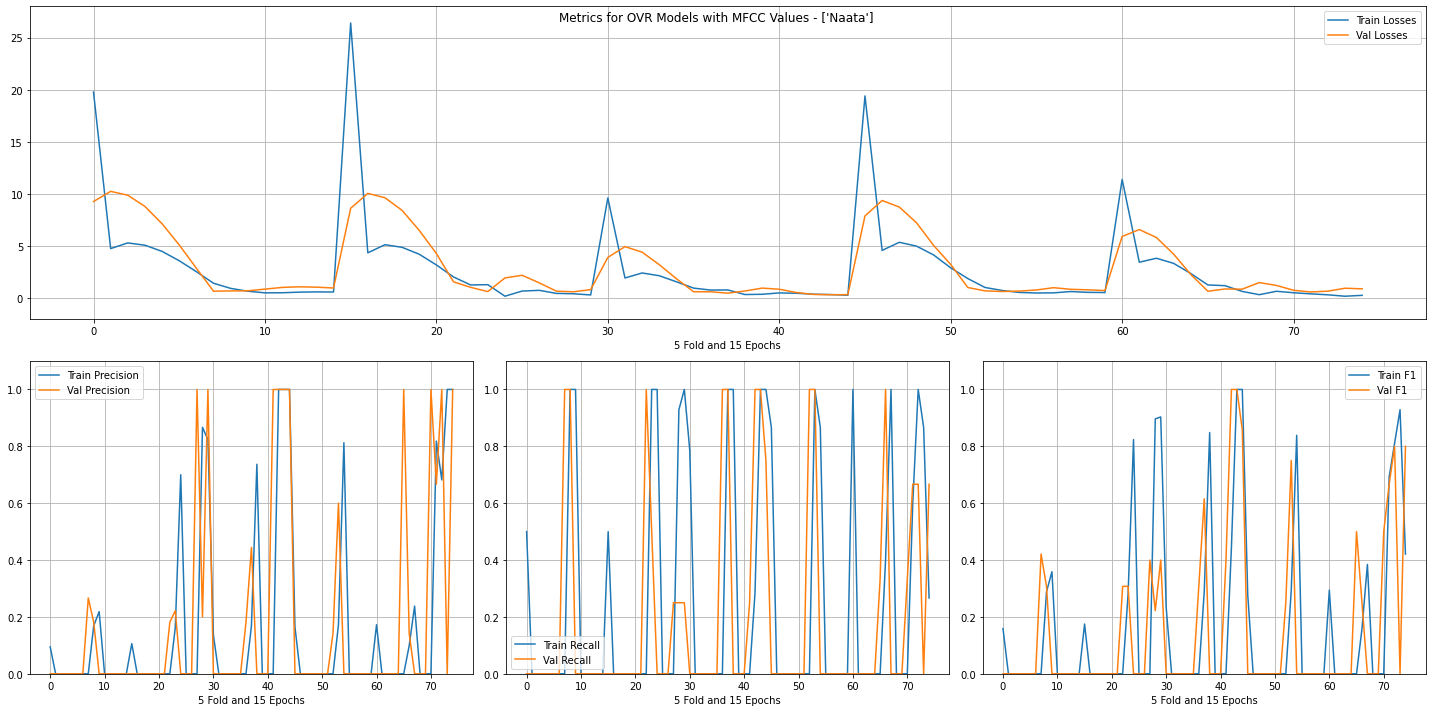

*** Cross Validation Score ***


Training for ['Nadaramakriya'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 264/66
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 10.316 / Validation Loss : 5.187 [Time : 1.259175 seconds]
Epoch 2/15 : Training Loss: 4.342 / Validation Loss : 3.360 [Time : 1.236031 seconds]
Epoch 3/15 : Training Loss: 2.748 / Validation Loss : 1.354 [Time : 1.283627 seconds]
Epoch 4/15 : Training Loss: 1.266 / Validation Loss : 0.538 [Time : 1.283427 seconds]
Epoch 5/15 : Training Loss: 0.505 / Validation Loss : 0.574 [Time : 0.806382 seconds]
Epoch 6/15 : Training Loss: 0.540 / Validation Loss : 0.566 [Time : 0.785501 seconds]
Epoch 7/15 : Training Loss: 0.529 / Validation Loss : 0.684 [Time : 0.786818 seconds]
Epoch 8/15 : Training Loss: 0.689 / Validation Loss : 0.559 [Time : 0.78775 seconds]
Epoch 9/15 : Training Loss: 0.606 / Validation Loss : 0.552 [Time : 0.785951 seconds]
Epoch 10/15 : Training Loss: 0.519 / Validation Loss : 0.564 [Time : 0.79064 seconds]
Epoch 11/15 : Tr

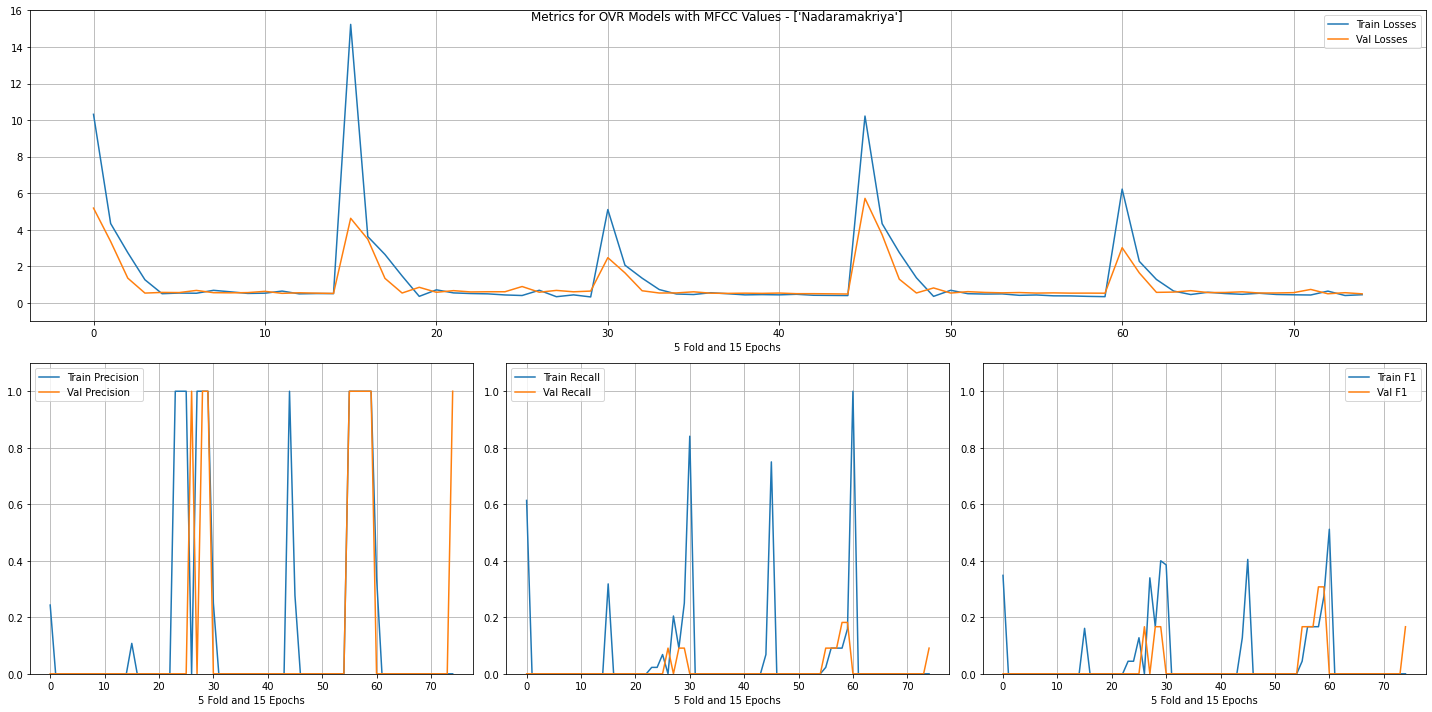

*** Cross Validation Score ***


Training for ['Paadi'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 292/74
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 11.208 / Validation Loss : 6.502 [Time : 1.324531 seconds]
Epoch 2/15 : Training Loss: 4.675 / Validation Loss : 4.382 [Time : 1.388017 seconds]
Epoch 3/15 : Training Loss: 3.080 / Validation Loss : 1.908 [Time : 1.388742 seconds]
Epoch 4/15 : Training Loss: 1.898 / Validation Loss : 0.973 [Time : 1.378452 seconds]
Epoch 5/15 : Training Loss: 0.742 / Validation Loss : 0.912 [Time : 1.394221 seconds]
Epoch 6/15 : Training Loss: 0.927 / Validation Loss : 0.747 [Time : 1.38896 seconds]
Epoch 7/15 : Training Loss: 0.588 / Validation Loss : 0.664 [Time : 1.384978 seconds]
Epoch 8/15 : Training Loss: 0.645 / Validation Loss : 0.675 [Time : 0.895861 seconds]
Epoch 9/15 : Training Loss: 0.538 / Validation Loss : 0.860 [Time : 0.889729 seconds]
Epoch 10/15 : Training Loss: 0.792 / Validation Loss : 0.682 [Time : 0.893761 seconds]
Epoch 11/15 : Training 

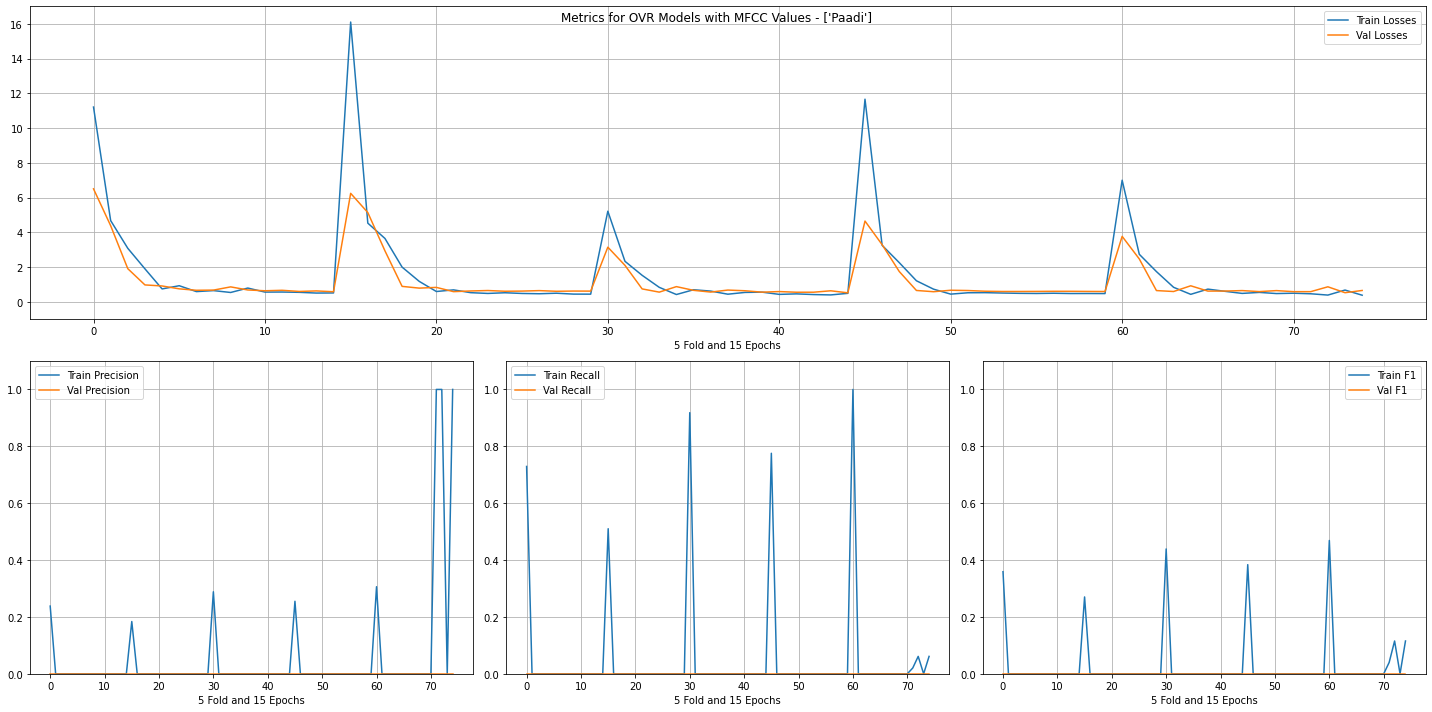

*** Cross Validation Score ***


Training for ['Ramakriya'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 470/118
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 13.312 / Validation Loss : 7.020 [Time : 1.881298 seconds]
Epoch 2/15 : Training Loss: 5.675 / Validation Loss : 4.036 [Time : 1.898771 seconds]
Epoch 3/15 : Training Loss: 3.102 / Validation Loss : 1.766 [Time : 1.892563 seconds]
Epoch 4/15 : Training Loss: 1.604 / Validation Loss : 0.547 [Time : 1.890684 seconds]
Epoch 5/15 : Training Loss: 0.357 / Validation Loss : 1.079 [Time : 1.418877 seconds]
Epoch 6/15 : Training Loss: 0.929 / Validation Loss : 0.556 [Time : 1.395966 seconds]
Epoch 7/15 : Training Loss: 0.599 / Validation Loss : 0.533 [Time : 1.884481 seconds]
Epoch 8/15 : Training Loss: 0.491 / Validation Loss : 0.558 [Time : 1.419314 seconds]
Epoch 9/15 : Training Loss: 0.523 / Validation Loss : 0.565 [Time : 1.408254 seconds]
Epoch 10/15 : Training Loss: 0.555 / Validation Loss : 0.543 [Time : 1.405912 seconds]
Epoch 11/15 : Tra

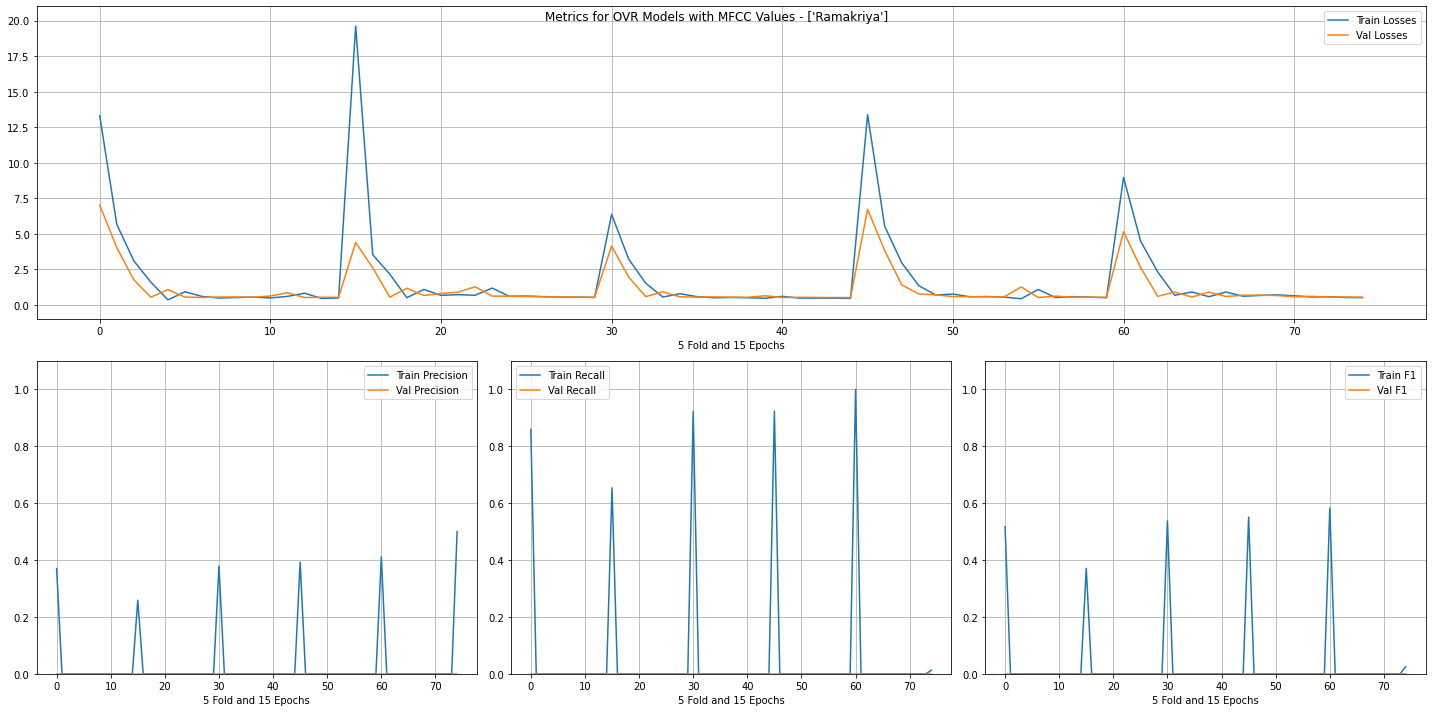

*** Cross Validation Score ***


Training for ['Salangam'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 105/27
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 16.536 / Validation Loss : 10.106 [Time : 0.795788 seconds]
Epoch 2/15 : Training Loss: 4.399 / Validation Loss : 10.383 [Time : 0.357509 seconds]
Epoch 3/15 : Training Loss: 4.492 / Validation Loss : 9.359 [Time : 0.824613 seconds]
Epoch 4/15 : Training Loss: 4.024 / Validation Loss : 7.653 [Time : 0.837241 seconds]
Epoch 5/15 : Training Loss: 3.264 / Validation Loss : 5.163 [Time : 0.823678 seconds]
Epoch 6/15 : Training Loss: 2.163 / Validation Loss : 2.672 [Time : 0.851237 seconds]
Epoch 7/15 : Training Loss: 1.214 / Validation Loss : 0.689 [Time : 0.834558 seconds]
Epoch 8/15 : Training Loss: 1.205 / Validation Loss : 0.682 [Time : 0.844102 seconds]
Epoch 9/15 : Training Loss: 0.285 / Validation Loss : 1.776 [Time : 0.350914 seconds]
Epoch 10/15 : Training Loss: 0.642 / Validation Loss : 2.138 [Time : 0.341949 seconds]
Epoch 11/15 : Tra

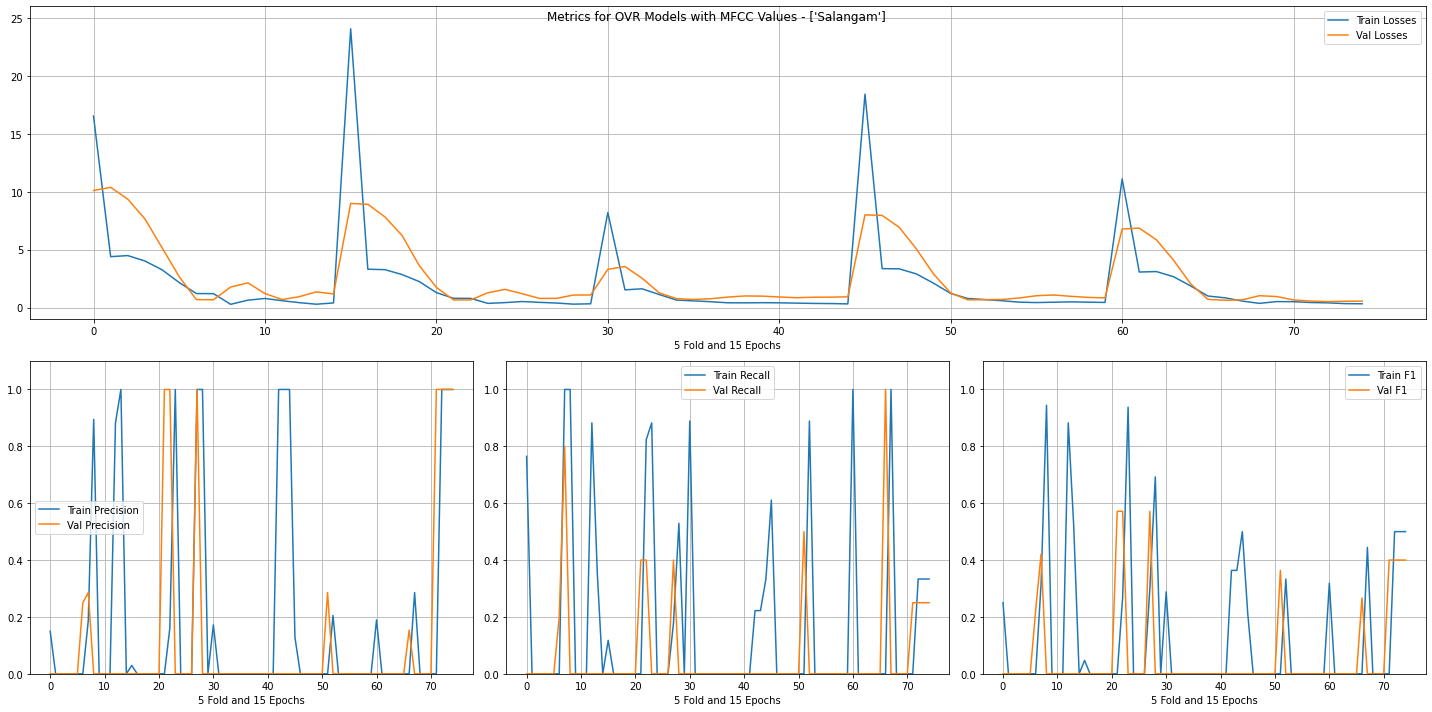

*** Cross Validation Score ***


Training for ['Salanganata'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 326/82
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.953 / Validation Loss : 5.316 [Time : 1.440132 seconds]
Epoch 2/15 : Training Loss: 3.424 / Validation Loss : 3.252 [Time : 1.473935 seconds]
Epoch 3/15 : Training Loss: 2.034 / Validation Loss : 1.662 [Time : 1.501359 seconds]
Epoch 4/15 : Training Loss: 1.197 / Validation Loss : 0.582 [Time : 1.482554 seconds]
Epoch 5/15 : Training Loss: 0.453 / Validation Loss : 1.090 [Time : 0.981819 seconds]
Epoch 6/15 : Training Loss: 0.809 / Validation Loss : 0.603 [Time : 0.969093 seconds]
Epoch 7/15 : Training Loss: 0.571 / Validation Loss : 0.606 [Time : 0.965354 seconds]
Epoch 8/15 : Training Loss: 0.466 / Validation Loss : 0.655 [Time : 0.970573 seconds]
Epoch 9/15 : Training Loss: 0.507 / Validation Loss : 0.632 [Time : 0.965332 seconds]
Epoch 10/15 : Training Loss: 0.507 / Validation Loss : 0.608 [Time : 0.955079 seconds]
Epoch 11/15 : Tr

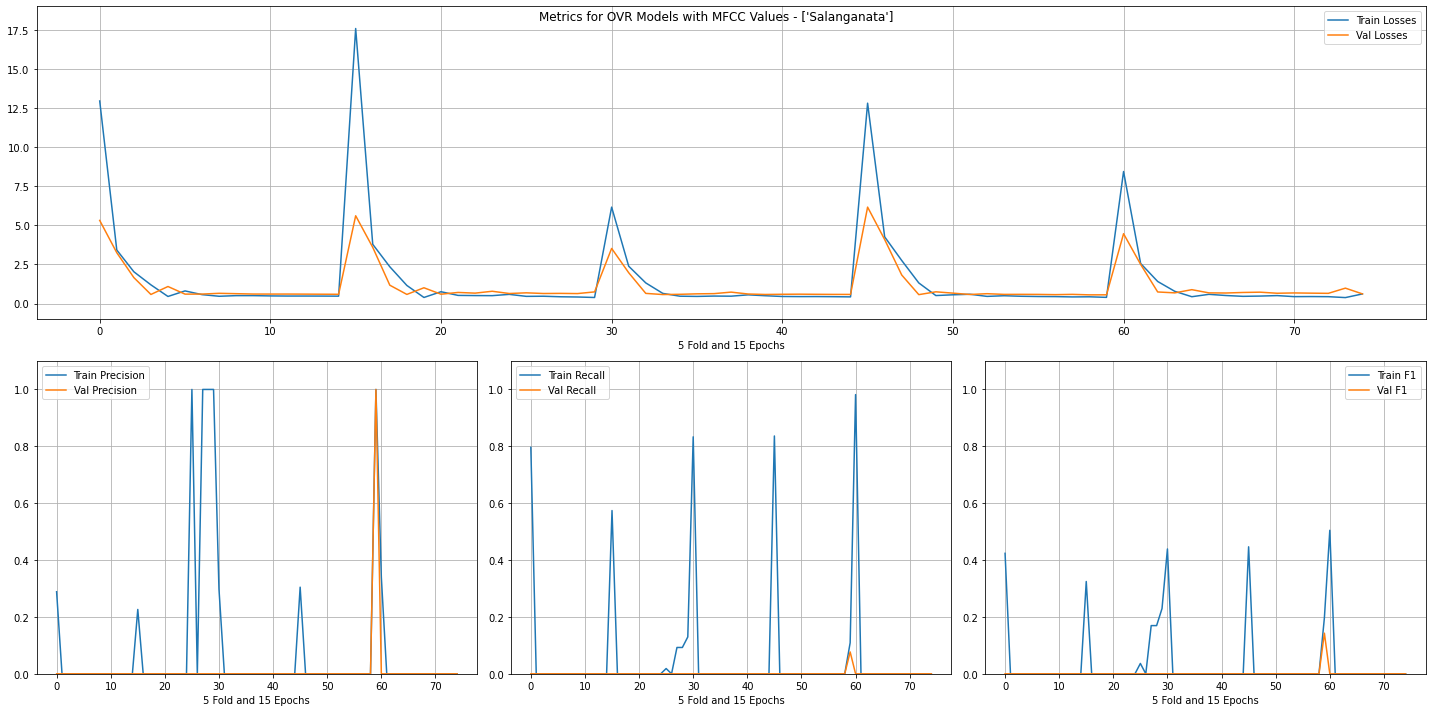

*** Cross Validation Score ***


Training for ['Samantham'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 158/40
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 17.007 / Validation Loss : 3.014 [Time : 0.97537 seconds]
Epoch 2/15 : Training Loss: 2.004 / Validation Loss : 2.441 [Time : 0.997421 seconds]
Epoch 3/15 : Training Loss: 1.618 / Validation Loss : 1.612 [Time : 1.002922 seconds]
Epoch 4/15 : Training Loss: 1.097 / Validation Loss : 0.735 [Time : 1.012396 seconds]
Epoch 5/15 : Training Loss: 0.582 / Validation Loss : 0.607 [Time : 0.998415 seconds]
Epoch 6/15 : Training Loss: 0.540 / Validation Loss : 0.587 [Time : 0.995775 seconds]
Epoch 7/15 : Training Loss: 0.510 / Validation Loss : 0.594 [Time : 0.513656 seconds]
Epoch 8/15 : Training Loss: 0.484 / Validation Loss : 0.611 [Time : 0.489005 seconds]
Epoch 9/15 : Training Loss: 0.471 / Validation Loss : 0.632 [Time : 0.487562 seconds]
Epoch 10/15 : Training Loss: 0.482 / Validation Loss : 0.633 [Time : 0.499821 seconds]
Epoch 11/15 : Train

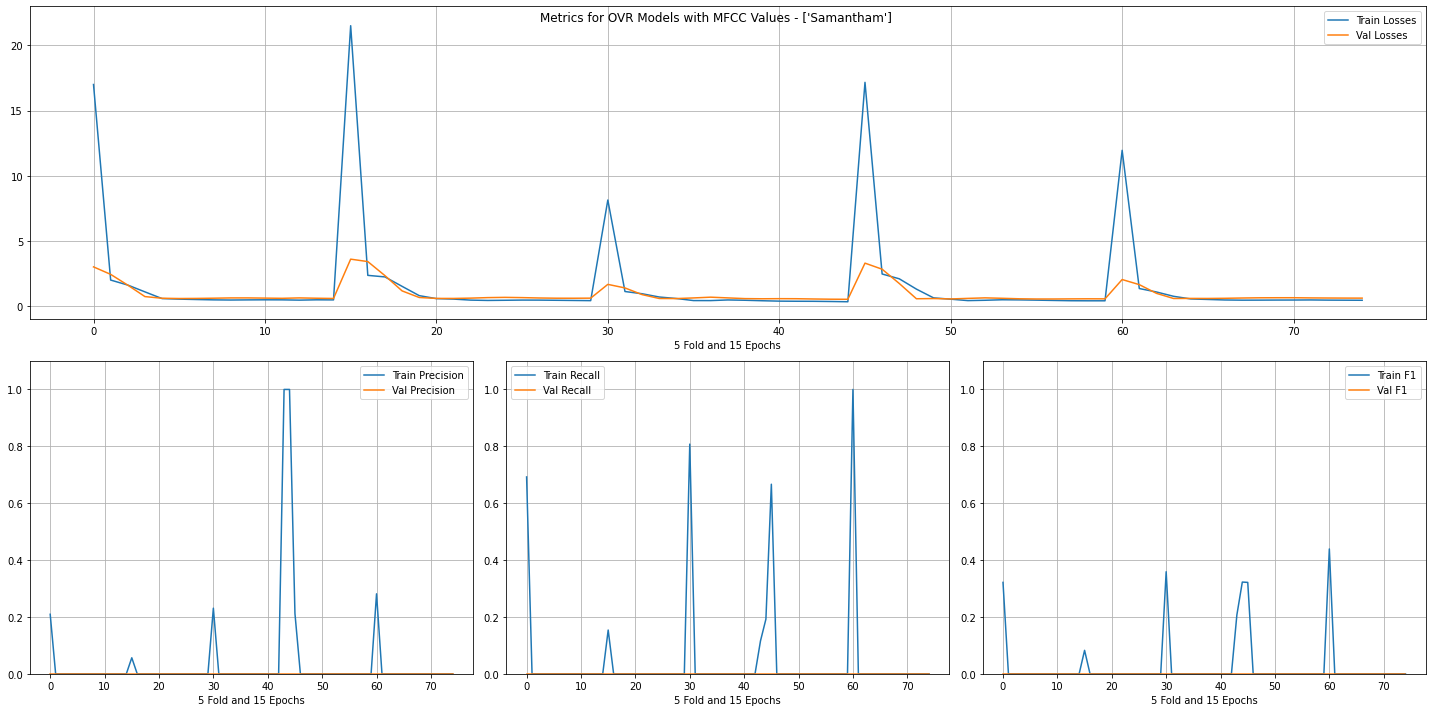

*** Cross Validation Score ***


Training for ['Sankarabharanam'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 312/78
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.906 / Validation Loss : 5.470 [Time : 1.409755 seconds]
Epoch 2/15 : Training Loss: 3.841 / Validation Loss : 3.629 [Time : 1.42116 seconds]
Epoch 3/15 : Training Loss: 2.491 / Validation Loss : 2.450 [Time : 1.415574 seconds]
Epoch 4/15 : Training Loss: 1.766 / Validation Loss : 0.581 [Time : 1.434473 seconds]
Epoch 5/15 : Training Loss: 0.583 / Validation Loss : 0.710 [Time : 0.949221 seconds]
Epoch 6/15 : Training Loss: 0.513 / Validation Loss : 1.013 [Time : 0.929126 seconds]
Epoch 7/15 : Training Loss: 0.805 / Validation Loss : 0.585 [Time : 0.923309 seconds]
Epoch 8/15 : Training Loss: 0.519 / Validation Loss : 0.682 [Time : 0.92858 seconds]
Epoch 9/15 : Training Loss: 0.479 / Validation Loss : 0.841 [Time : 0.93302 seconds]
Epoch 10/15 : Training Loss: 0.575 / Validation Loss : 0.898 [Time : 0.915248 seconds]
Epoch 11/15 : T

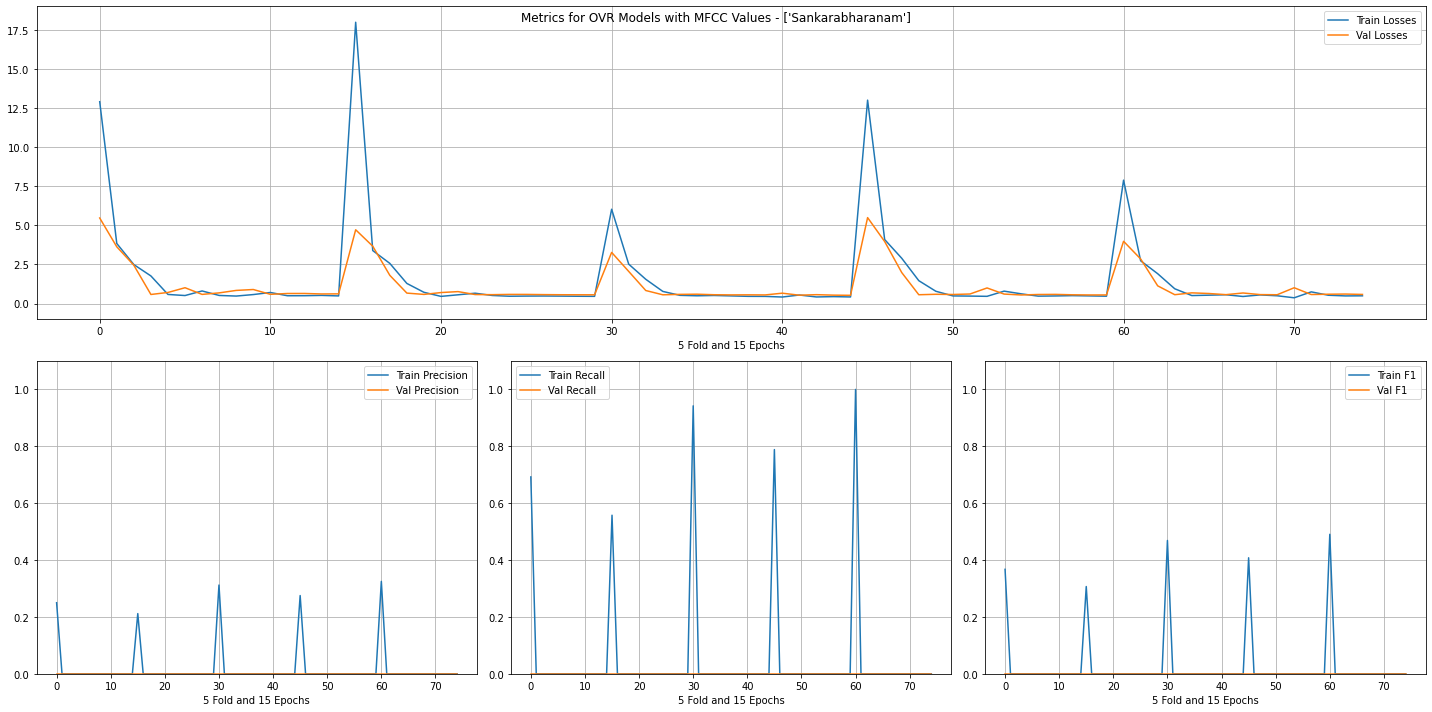

*** Cross Validation Score ***


Training for ['Sriragam'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 427/107
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 13.515 / Validation Loss : 4.997 [Time : 1.729806 seconds]
Epoch 2/15 : Training Loss: 4.036 / Validation Loss : 1.905 [Time : 1.737332 seconds]
Epoch 3/15 : Training Loss: 1.513 / Validation Loss : 0.638 [Time : 1.769895 seconds]
Epoch 4/15 : Training Loss: 0.710 / Validation Loss : 0.990 [Time : 1.254698 seconds]
Epoch 5/15 : Training Loss: 0.896 / Validation Loss : 0.756 [Time : 1.249628 seconds]
Epoch 6/15 : Training Loss: 0.798 / Validation Loss : 0.665 [Time : 1.255543 seconds]
Epoch 7/15 : Training Loss: 0.628 / Validation Loss : 0.662 [Time : 1.26587 seconds]
Epoch 8/15 : Training Loss: 0.689 / Validation Loss : 0.635 [Time : 1.728182 seconds]
Epoch 9/15 : Training Loss: 0.615 / Validation Loss : 0.587 [Time : 1.727583 seconds]
Epoch 10/15 : Training Loss: 0.572 / Validation Loss : 0.586 [Time : 1.752237 seconds]
Epoch 11/15 : Train

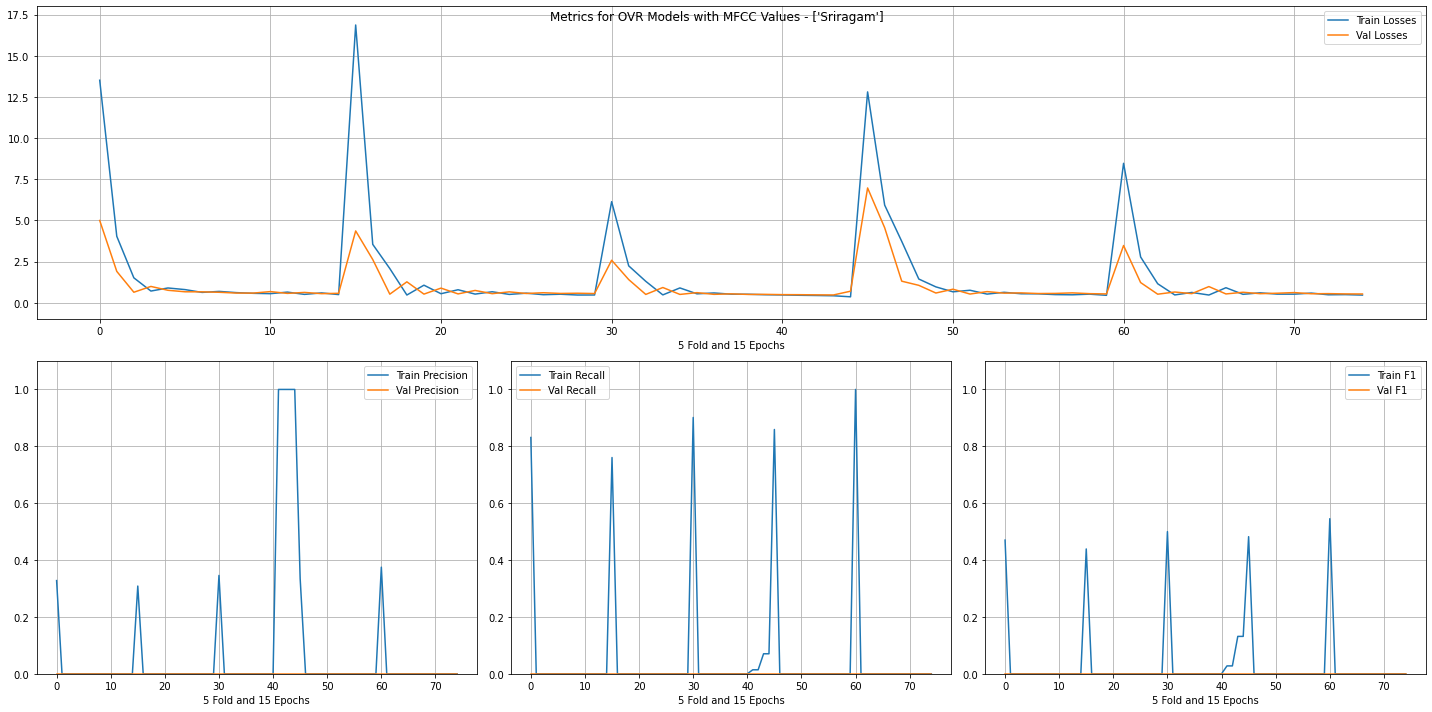

*** Cross Validation Score ***


Training for ['Suddavasantham'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 52/14
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 15.770 / Validation Loss : 4.027 [Time : 0.671747 seconds]
Epoch 2/15 : Training Loss: 1.831 / Validation Loss : 7.009 [Time : 0.198315 seconds]
Epoch 3/15 : Training Loss: 3.293 / Validation Loss : 2.555 [Time : 0.672937 seconds]
Epoch 4/15 : Training Loss: 2.292 / Validation Loss : 0.621 [Time : 0.68459 seconds]
Epoch 5/15 : Training Loss: 0.143 / Validation Loss : 4.568 [Time : 0.19269 seconds]
Epoch 6/15 : Training Loss: 0.984 / Validation Loss : 3.636 [Time : 0.201067 seconds]
Epoch 7/15 : Training Loss: 0.500 / Validation Loss : 1.140 [Time : 0.191611 seconds]
Epoch 8/15 : Training Loss: 0.326 / Validation Loss : 0.808 [Time : 0.196809 seconds]
Epoch 9/15 : Training Loss: 0.046 / Validation Loss : 2.464 [Time : 0.186475 seconds]
Epoch 10/15 : Training Loss: 0.016 / Validation Loss : 3.559 [Time : 0.196253 seconds]
Epoch 11/15 : Tr

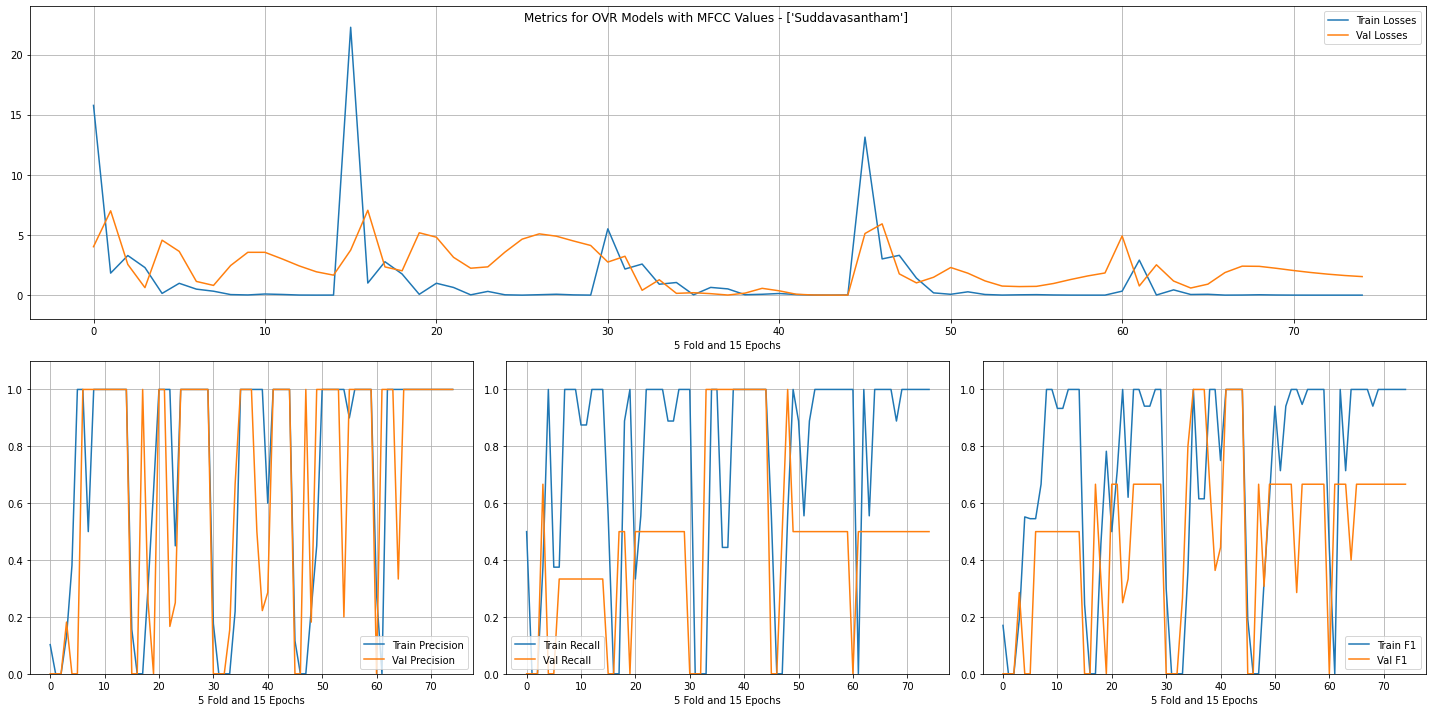

*** Cross Validation Score ***


Training for ['Varali'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 451/113
Class Weights : [0.6 3. ]
Epoch 1/15 : Training Loss: 12.981 / Validation Loss : 5.953 [Time : 1.862879 seconds]
Epoch 2/15 : Training Loss: 4.824 / Validation Loss : 2.916 [Time : 1.888418 seconds]
Epoch 3/15 : Training Loss: 2.227 / Validation Loss : 0.714 [Time : 1.86751 seconds]
Epoch 4/15 : Training Loss: 0.866 / Validation Loss : 0.523 [Time : 1.902619 seconds]
Epoch 5/15 : Training Loss: 0.436 / Validation Loss : 0.637 [Time : 1.392371 seconds]
Epoch 6/15 : Training Loss: 0.565 / Validation Loss : 0.647 [Time : 1.38804 seconds]
Epoch 7/15 : Training Loss: 0.529 / Validation Loss : 1.073 [Time : 1.386237 seconds]
Epoch 8/15 : Training Loss: 0.938 / Validation Loss : 0.545 [Time : 1.389303 seconds]
Epoch 9/15 : Training Loss: 0.559 / Validation Loss : 0.758 [Time : 1.392464 seconds]
Epoch 10/15 : Training Loss: 0.719 / Validation Loss : 0.545 [Time : 1.384785 seconds]
Epoch 11/15 : Training

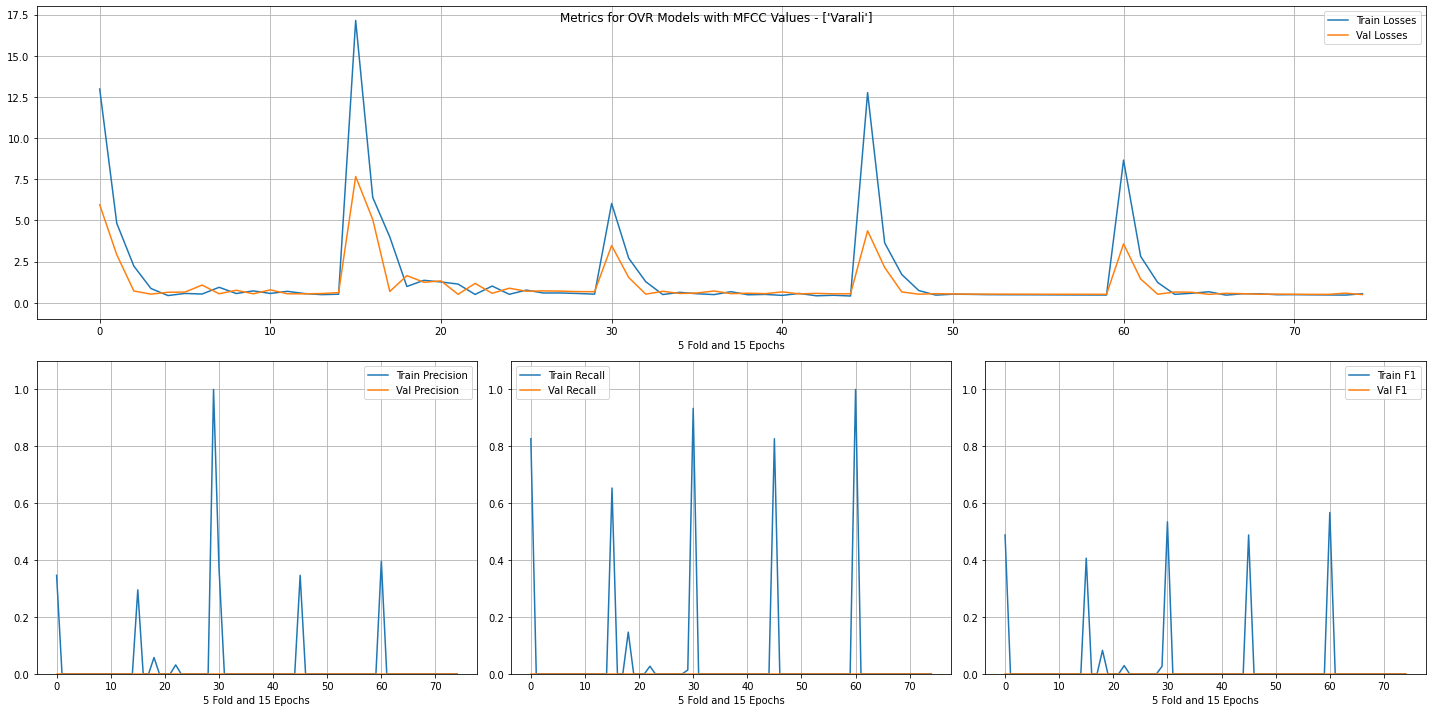

*** Cross Validation Score ***


In [10]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MfccMatrixDataset, MfccRaga, "OVR Models with MFCC Values", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-4, epochs=15, n_folds=5, feature='mfcc',nindex_factor=5)

In [12]:
tab = pd.DataFrame(columns=['Raga','Train Confusion','Test Confusion'] + list(ovr_res[list(ovr_res.keys())[0]][1].keys()))
idx = 0
nresults = 1
for r in ovr_res:
  # Get top "nresults"
  tmp = results_to_df(ovr_res[r]).head(nresults)
  for _ in range(nresults):
    tab.loc[idx,'Raga'] = le.inverse_transform([r])[0]
    for i in tmp.columns:
      tab.loc[idx,i] = tmp[i].tolist()[_]
    t = confusion_matrix(tab.loc[idx,'train_labels'][0],tab.loc[idx,'train_predictions'][0])
    tab.loc[idx,'Train Confusion'] = str(t[0]) + '\n' +str(t[1])
    t = confusion_matrix(tab.loc[idx,'validation_labels'][0],tab.loc[idx,'validation_predictions'][0])
    tab.loc[idx,'Test Confusion'] = str(t[0]) + '\n' +str(t[1])
    idx = idx + 1

In [13]:
from IPython.display import display, HTML
display( HTML( tab[['Raga','Train Confusion','Test Confusion','train_f1','validation_f1','train_precision','validation_precision','train_recall','validation_recall']].to_html().replace("\\n","<br>") ) )

In [14]:
tab.index = tab['Raga']

In [15]:
def bar_plot(df, cols, title):
  df[cols].plot.bar(figsize=[20,5],grid=True)
  plt.title(title)
  plt.legend(['Train','Validation'])
  plt.xticks(rotation=45)
  plt.show()

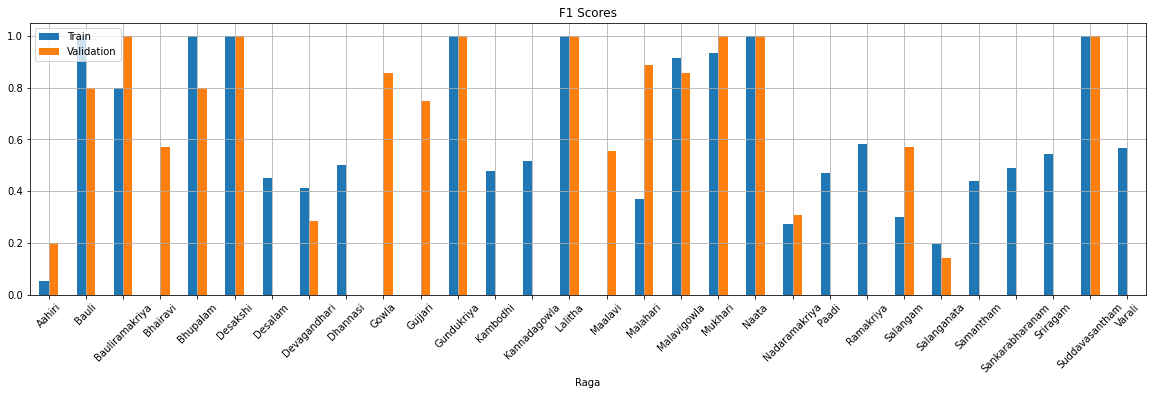

In [16]:
bar_plot(tab, ['train_f1','validation_f1'],'F1 Scores')

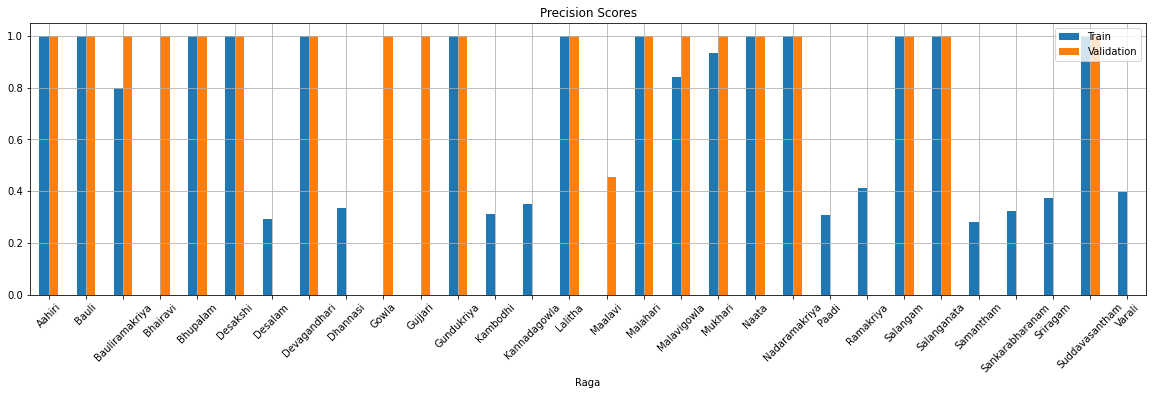

In [17]:
bar_plot(tab, ['train_precision','validation_precision'],'Precision Scores')

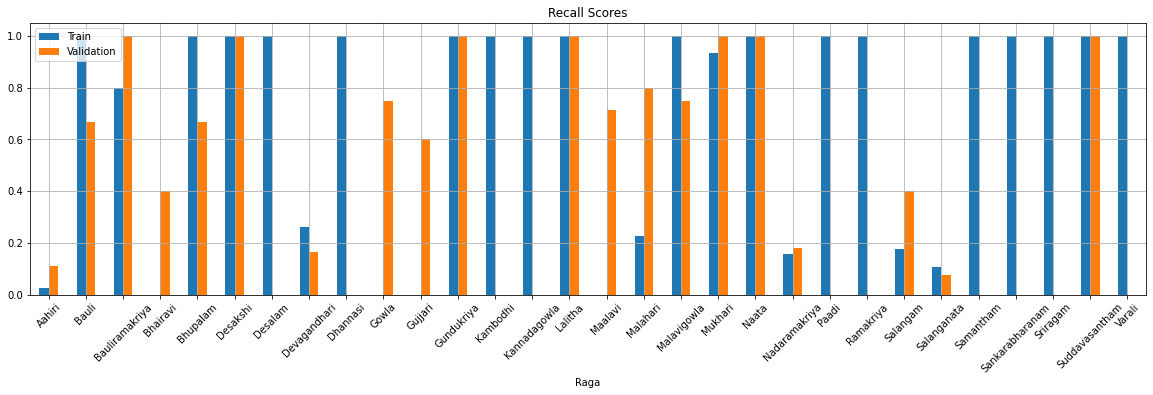

In [18]:
bar_plot(tab, ['train_recall','validation_recall'],'Recall Scores')